# **Higgs Boson Signal Process Discrimination**
# 2. Training, Evaluation and Testing

This notebook contains the implementation of a GPU-based machine learning technique for discriminating between a signal process that produces Higgs bosons and a background process that does not. The proposed machine learning technique utilises the RAPIDS framework for parallel processing. 

In [1]:
import cudf
import pandas as pd
import cupy as cp
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import time

import warnings
warnings.filterwarnings('ignore')
matplotlib.use("Agg")
%matplotlib inline

---
## 2.1 Model training

In this stage, different model will be trained and validated using the training and validation sets. The models will then be compared to determine the most suitable machine learning method for the task at hand.

The following functions will be used for the evaluation of the results.

In [2]:
from cuml.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

def _sensitivity(y_actual, y_pred):
    """Calculate the sensitivity score per class for a model"""
    cm = confusion_matrix(y_actual, y_pred)
    FN = cm[1, 0].item()
    TP = cm[1, 1].item()
    
    if(not TP): # avoid Nan values if both TP and FN are 0s
        sensitivity = 0.0
    else:
        sensitivity = round((TP / (TP + FN)), 2)
        
    return sensitivity

def _specificity(y_actual, y_pred):
    """Calculate the specificity score per class for a model"""
    cm = confusion_matrix(y_actual, y_pred)
    TN = cm[0, 0].item()
    FP = cm[0, 1].item()
    
    if(not TN): # avoid Nan values if both TN and FP are 0s
        specificity = 0.0
    else:
        specificity = round((TN / (TN + FP)), 2)
        
    return specificity

def report(y_actual, y_pred):
    """Print a report with all evaluation metrics for a model"""
    print(classification_report(y_actual.get(), y_pred.get()))
    sensitivity = _sensitivity(y_actual, y_pred)
    print('Sensitivity: ', sensitivity)
    specificity = _specificity(y_actual, y_pred)
    print('Specificity: ', specificity)
    
    cm_matrix = confusion_matrix(y_actual,y_pred)
    sns.heatmap(cm_matrix.get(), annot=True)

First, the datasets are loaded.

In [3]:
def load_data_sets(prefix=''):
    if prefix != '':
        prefix += '-'

    print('loading training set...', end='');
    X_train = cudf.read_csv('./datasets/{}X_train.csv'.format(prefix))
    y_train = cudf.read_csv('./datasets/{}y_train.csv'.format(prefix))
    print('done!')
    
    print('loading validation set...', end='');
    X_val = cudf.read_csv('./datasets/{}X_val.csv'.format(prefix))
    y_val = cudf.read_csv('./datasets/{}y_val.csv'.format(prefix))
    print('done!')
    
    print('loading test set...', end='');
    X_test = cudf.read_csv('./datasets/{}X_test.csv'.format(prefix))
    y_test = cudf.read_csv('./datasets/{}y_test.csv'.format(prefix))
    print('done!')
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
''' The datasets without normalisation and standardisation '''
X_train_resampled, y_train_resampled, X_val_resampled, y_val_resampled, X_test_resampled, y_test_resampled = load_data_sets('resampled')

loading training set...done!
loading validation set...done!
loading test set...done!


In [5]:
''' The datasets with normalisation and standardisation '''
X_train, y_train, X_val, y_val, X_test, y_test = load_data_sets()

loading training set...done!
loading validation set...done!
loading test set...done!


### 2.1.1. Logistic Regression

To start things slow, a logistic regression model is trained for baseline comparison. To decide on the optimal set of parameters, a grid search is employed.

In [6]:
from cuml import LogisticRegression

def cLR_grid_search(penalty, linesearch_max_iter, X_train=X_train, X_val=X_val):
    start = time.time()
    max_acc = 0
    classifier = None
    best_params = ()
    
    for d in penalty:
        for n in linesearch_max_iter:
            print('penalty: {}, linesearch_max_iter: {} ==> '.format(d, n), end='')
            cLR = LogisticRegression(penalty = d, linesearch_max_iter = n)
            cLR.fit(X_train, y_train)

            val_pred = cLR.predict(X_val)
            acc = round(accuracy_score(y_val['process'].to_cupy(), cp.array(val_pred)) * 100, 2)
            print('val accuracy = ', acc)

            if acc > max_acc:
                max_acc = acc
                classifier = cLR
                best_params = (d, n)
    
    end = time.time()
    print('Time passed: {} seconds.'.format(round(end - start, 2)))
    return classifier, best_params, max_acc

In [7]:
cLR, best_params = cLR_grid_search(['l1', 'l2'], [50, 75, 100])
best_params

penalty: l1, linesearch_max_iter: 50 ==> val accuracy =  60.81
penalty: l1, linesearch_max_iter: 75 ==> val accuracy =  60.81
penalty: l1, linesearch_max_iter: 100 ==> val accuracy =  60.81
penalty: l2, linesearch_max_iter: 50 ==> val accuracy =  60.82
penalty: l2, linesearch_max_iter: 75 ==> val accuracy =  60.82
penalty: l2, linesearch_max_iter: 100 ==> val accuracy =  60.82
Time passed: 19.46 seconds.


('l2', 100)

After running the grid search, the best validation accuracy obtained across all trials is 60.8%. The best set of parameters to achieve this accuracy are `l2` for penalty and maximum of a 100 linesearch iterations.

The process of fitting 6 versions of the model to find the best set of hyperparameters took 19.65 seconds using RAPIDS framework. To compare the effeciency of this library for the current task, a Logistic regression model from the scikit learn library will be trained on CPU. The classifier will be trained using the same parameters chosen by the previous grid search.

In [8]:
from sklearn.linear_model import LogisticRegression as sk_LogisticRegression

X = X_train.to_pandas()
y = y_train.to_pandas()
val_X = X_val.to_pandas()
val_y = y_val['process'].to_cupy().get()

start = time.time()
print('penalty: {}, linesearch_max_iter: {} ==> '.format('l2', 100), end='')
skLR = sk_LogisticRegression(solver='liblinear', penalty = 'l2', max_iter = 100)
skLR.fit(X, y)

val_pred = skLR.predict(val_X)
acc = round(accuracy_score(val_y, np.array(val_pred)) * 100, 2)
print('val accuracy = ', acc)

end = time.time()
print('Time passed: {} seconds.'.format(round(end - start, 2)))

penalty: l2, linesearch_max_iter: 100 ==> val accuracy =  60.83
Time passed: 42.65 seconds.


The CPU based classifier finished training for a single classifier in 42 seconds. This is almost double the time it took cuML to train and evaluate 6 models. This proves the superiority of the RAPIDS framework for handling larger datasets such as the current one.

The cuML model is evaluated against the validation set

In [9]:
y_pred_rf = cLR.predict(X_val)
round(accuracy_score(y_val['process'].to_cupy(), cp.array(y_pred_rf)) * 100, 2)

60.82

              precision    recall  f1-score   support

           0       0.58      0.62      0.60    305879
           1       0.64      0.60      0.62    347624

    accuracy                           0.61    653503
   macro avg       0.61      0.61      0.61    653503
weighted avg       0.61      0.61      0.61    653503

Sensitivity:  0.6
Specificity:  0.62


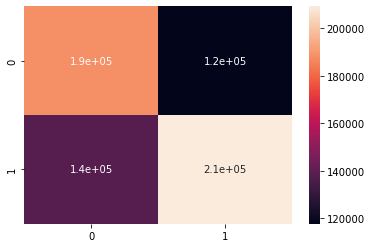

In [10]:
report(y_val['process'].to_cupy(), cp.array(y_pred_rf))

The results show an accuracy of 61% for the current model with 61% percision and recall. This accuracy is not great but it is expected. The logistic regression model is relatively simple for this complex task. Further experimentation could be applied to achieve better results with other more complex models.

### 2.1.2. Random Forest

The second model to be trained is a Random Forest classifier. cuML offers a GPU based implementation of the classifier which will be used for this task. To decide on the optimal set of parameters, a grid search is employed.

In [7]:
from cuml.ensemble import RandomForestClassifier as cuRF

def crf_grid_search(max_depths, n_estimators, X_train=X_train, X_val=X_val):
    max_acc = 0
    classifier = None
    best_params = ()
    
    for d in max_depths:
        for n in n_estimators:
            print('max_depth: {}, n_estimators: {} ==> '.format(d, n), end='')
            model_rf = cuRF(max_depth = d, n_estimators = n)
            model_rf.fit(X_train, y_train)

            val_pred = model_rf.predict(X_val)
            acc = round(accuracy_score(y_val['process'].to_cupy(), cp.array(val_pred)) * 100, 2)
            print('val accuracy = ', acc)

            if acc > max_acc:
                max_acc = acc
                classifier = model_rf
                best_params = (d, n)
                
    return classifier, best_params, max_acc

In [8]:
max_depths = [10, 30, 50]
n_estimators = [25, 45]
crf_grid_search(max_depths, n_estimators)

max_depth: 10, n_estimators: 25 ==> val accuracy =  68.75
max_depth: 10, n_estimators: 45 ==> val accuracy =  68.92
max_depth: 30, n_estimators: 25 ==> val accuracy =  71.81
max_depth: 30, n_estimators: 45 ==> val accuracy =  72.41
max_depth: 50, n_estimators: 25 ==> val accuracy =  71.7
max_depth: 50, n_estimators: 45 ==> val accuracy =  72.4


(RandomForestClassifier(), (30, 45), 72.41)

By analysing the previous results, it appears that there is a general trend of increasing accuracy as the maximum depth and number of estimators increase. To test this hypothesis, a classifier is trained using a maximum depth of 70 and 100 as the number of estimators.

In [8]:
print('max_depth: 70, n_estimators: 100 ==> ', end='')
cRF = cuRF(max_depth = 70, n_estimators = 100)
cRF.fit(X_train, y_train)

val_pred = cRF.predict(X_val)
acc = round(accuracy_score(y_val['process'].to_cupy(), cp.array(val_pred)) * 100, 2)
print('val accuracy = ', acc)

max_depth: 70, n_estimators: 100 ==> val accuracy =  72.89


Although increasing both hyperparameter values has improved the accuracy, the improvement is not substantial. Further increasing the hyperparameter values may improve accuracy, but it would also increase the computational cost without providing a significant improvement in accuracy. For this reason, the previous set of hyperparameters (70, 100) will be used without further experimentation.

The chosen model is evaluated against the validation set

In [10]:
y_pred_rf = cRF.predict(X_val)
round(accuracy_score(y_val['process'].to_cupy(), cp.array(y_pred_rf)) * 100, 2)

72.89

              precision    recall  f1-score   support

           0       0.70      0.74      0.72    305879
           1       0.76      0.72      0.74    347624

    accuracy                           0.73    653503
   macro avg       0.73      0.73      0.73    653503
weighted avg       0.73      0.73      0.73    653503

Sensitivity:  0.72
Specificity:  0.74


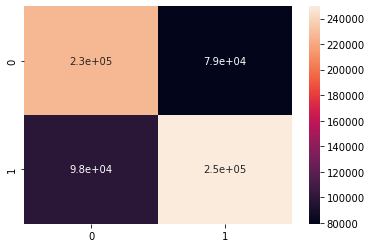

In [11]:
report(y_val['process'].to_cupy(), cp.array(y_pred_rf))

The model achieved 73% accuracy, percision and recall. The results are definitely an improvement from the logistic regression model.

### 2.1.3. Gradient boosted trees

The third and final model trained in the current dataset is XGBoost (eXtreme Gradient Boosting), a more regularised form of Gradient Boosting. Learning API offers a Python package for XGBoost implementation , which will be used for this project. 

In [6]:
import xgboost as xgb

A simple grid search will be used to decide on the optimal value for max_depth.

In [7]:
def train(data, label, rounds=1200, model=None):
    dtrain = xgb.DMatrix(data, label)
    dval = xgb.DMatrix(data= X_val, label=y_val)
    evallist = [(dtrain, 'train'), (dval, 'eval')]
    
    params = {}
    evals_result = {}
    
    params['tree_method'] = 'gpu_hist'
    params['objective'] = 'binary:hinge'
    params['booster'] = 'gbtree'

    max_depth = [3, 5, 7, 8]
    max_acc = 0
    classifier = None
    best_evals_result = {}
    best_params = ()

    for d in max_depth:
        _params = params.copy()
        _params['max_depth'] = d
        
        print('#' * 15)
        print(_params)
        print('-' * 15)
        
        bst = xgb.train(params=_params, dtrain=dtrain, num_boost_round=rounds, evals=evallist, evals_result=evals_result, xgb_model=model)
        y_pred = bst.predict(dval).astype(int)
        acc = accuracy_score(y_val.to_cupy(), cp.array(y_pred))

        if acc > max_acc:
            max_acc = acc
            classifier = bst
            best_evals_result = evals_result
            best_params = _params
    
    return classifier, best_evals_result, max_acc, best_params

def plot_error_curves(evals_result):
    plt.plot(evals_result['train']['error'])
    plt.plot(evals_result['eval']['error'])
    plt.show()

The XGBoost will trained twice using two sets of data. The first set is the resampled data before normalisation and standardisation. The second set is the final version of the data after normalisation and standardisation. The goal of this experiment is to see the effect of normalisation and standardisation stages on the quiality of the training data.

In [8]:
bst, evals_result, acc, best_params = train(data=X_train_resampled, label=y_train_resampled)

###############
{'tree_method': 'gpu_hist', 'objective': 'binary:hinge', 'booster': 'gbtree', 'max_depth': 3}
---------------
[0]	train-error:0.50000	eval-error:0.46806
[1]	train-error:0.50000	eval-error:0.46806
[2]	train-error:0.45811	eval-error:0.46806
[3]	train-error:0.45811	eval-error:0.46806
[4]	train-error:0.43296	eval-error:0.46806
[5]	train-error:0.38455	eval-error:0.46807
[6]	train-error:0.38173	eval-error:0.46807
[7]	train-error:0.38032	eval-error:0.46807
[8]	train-error:0.38008	eval-error:0.46807
[9]	train-error:0.37989	eval-error:0.46807
[10]	train-error:0.37607	eval-error:0.46807
[11]	train-error:0.35724	eval-error:0.56001
[12]	train-error:0.35519	eval-error:0.56000
[13]	train-error:0.35430	eval-error:0.56000
[14]	train-error:0.35232	eval-error:0.56002
[15]	train-error:0.35283	eval-error:0.56002
[16]	train-error:0.35183	eval-error:0.55999
[17]	train-error:0.35077	eval-error:0.55819
[18]	train-error:0.35005	eval-error:0.55819
[19]	train-error:0.34942	eval-error:0.55642
[20]

[182]	train-error:0.30654	eval-error:0.53649
[183]	train-error:0.30643	eval-error:0.53650
[184]	train-error:0.30634	eval-error:0.53651
[185]	train-error:0.30623	eval-error:0.53651
[186]	train-error:0.30614	eval-error:0.53651
[187]	train-error:0.30599	eval-error:0.53647
[188]	train-error:0.30596	eval-error:0.53647
[189]	train-error:0.30584	eval-error:0.53648
[190]	train-error:0.30573	eval-error:0.53648
[191]	train-error:0.30570	eval-error:0.53645
[192]	train-error:0.30560	eval-error:0.53644
[193]	train-error:0.30559	eval-error:0.53644
[194]	train-error:0.30549	eval-error:0.53642
[195]	train-error:0.30545	eval-error:0.53627
[196]	train-error:0.30538	eval-error:0.53627
[197]	train-error:0.30536	eval-error:0.53627
[198]	train-error:0.30534	eval-error:0.53627
[199]	train-error:0.30523	eval-error:0.53620
[200]	train-error:0.30514	eval-error:0.53620
[201]	train-error:0.30513	eval-error:0.53619
[202]	train-error:0.30507	eval-error:0.53621
[203]	train-error:0.30496	eval-error:0.53622
[204]	trai

[365]	train-error:0.29723	eval-error:0.53217
[366]	train-error:0.29719	eval-error:0.53214
[367]	train-error:0.29716	eval-error:0.53214
[368]	train-error:0.29717	eval-error:0.53214
[369]	train-error:0.29716	eval-error:0.53215
[370]	train-error:0.29714	eval-error:0.53213
[371]	train-error:0.29711	eval-error:0.53215
[372]	train-error:0.29709	eval-error:0.53215
[373]	train-error:0.29707	eval-error:0.53216
[374]	train-error:0.29707	eval-error:0.53216
[375]	train-error:0.29705	eval-error:0.53218
[376]	train-error:0.29700	eval-error:0.53218
[377]	train-error:0.29694	eval-error:0.53217
[378]	train-error:0.29693	eval-error:0.53214
[379]	train-error:0.29692	eval-error:0.53211
[380]	train-error:0.29690	eval-error:0.53209
[381]	train-error:0.29689	eval-error:0.53206
[382]	train-error:0.29688	eval-error:0.53207
[383]	train-error:0.29688	eval-error:0.53208
[384]	train-error:0.29688	eval-error:0.53208
[385]	train-error:0.29688	eval-error:0.53206
[386]	train-error:0.29685	eval-error:0.53206
[387]	trai

[548]	train-error:0.29237	eval-error:0.53175
[549]	train-error:0.29236	eval-error:0.53175
[550]	train-error:0.29234	eval-error:0.53175
[551]	train-error:0.29233	eval-error:0.53175
[552]	train-error:0.29233	eval-error:0.53175
[553]	train-error:0.29232	eval-error:0.53175
[554]	train-error:0.29232	eval-error:0.53175
[555]	train-error:0.29231	eval-error:0.53175
[556]	train-error:0.29229	eval-error:0.53175
[557]	train-error:0.29224	eval-error:0.53175
[558]	train-error:0.29224	eval-error:0.53175
[559]	train-error:0.29217	eval-error:0.53175
[560]	train-error:0.29215	eval-error:0.53174
[561]	train-error:0.29216	eval-error:0.53174
[562]	train-error:0.29211	eval-error:0.53174
[563]	train-error:0.29212	eval-error:0.53176
[564]	train-error:0.29205	eval-error:0.53176
[565]	train-error:0.29201	eval-error:0.53176
[566]	train-error:0.29200	eval-error:0.53176
[567]	train-error:0.29198	eval-error:0.53175
[568]	train-error:0.29196	eval-error:0.53175
[569]	train-error:0.29195	eval-error:0.53175
[570]	trai

[731]	train-error:0.28891	eval-error:0.53171
[732]	train-error:0.28890	eval-error:0.53172
[733]	train-error:0.28890	eval-error:0.53172
[734]	train-error:0.28888	eval-error:0.53171
[735]	train-error:0.28886	eval-error:0.53171
[736]	train-error:0.28885	eval-error:0.53171
[737]	train-error:0.28885	eval-error:0.53171
[738]	train-error:0.28885	eval-error:0.53171
[739]	train-error:0.28883	eval-error:0.53171
[740]	train-error:0.28885	eval-error:0.53171
[741]	train-error:0.28884	eval-error:0.53171
[742]	train-error:0.28882	eval-error:0.53172
[743]	train-error:0.28882	eval-error:0.53171
[744]	train-error:0.28881	eval-error:0.53171
[745]	train-error:0.28880	eval-error:0.53172
[746]	train-error:0.28880	eval-error:0.53171
[747]	train-error:0.28880	eval-error:0.53171
[748]	train-error:0.28879	eval-error:0.53171
[749]	train-error:0.28879	eval-error:0.53171
[750]	train-error:0.28879	eval-error:0.53171
[751]	train-error:0.28877	eval-error:0.53171
[752]	train-error:0.28875	eval-error:0.53172
[753]	trai

[914]	train-error:0.28662	eval-error:0.53170
[915]	train-error:0.28660	eval-error:0.53170
[916]	train-error:0.28660	eval-error:0.53170
[917]	train-error:0.28658	eval-error:0.53170
[918]	train-error:0.28658	eval-error:0.53170
[919]	train-error:0.28653	eval-error:0.53170
[920]	train-error:0.28653	eval-error:0.53170
[921]	train-error:0.28651	eval-error:0.53170
[922]	train-error:0.28651	eval-error:0.53170
[923]	train-error:0.28650	eval-error:0.53169
[924]	train-error:0.28649	eval-error:0.53168
[925]	train-error:0.28649	eval-error:0.53170
[926]	train-error:0.28647	eval-error:0.53169
[927]	train-error:0.28647	eval-error:0.53169
[928]	train-error:0.28646	eval-error:0.53169
[929]	train-error:0.28646	eval-error:0.53169
[930]	train-error:0.28646	eval-error:0.53169
[931]	train-error:0.28645	eval-error:0.53169
[932]	train-error:0.28644	eval-error:0.53169
[933]	train-error:0.28641	eval-error:0.53169
[934]	train-error:0.28641	eval-error:0.53169
[935]	train-error:0.28639	eval-error:0.53169
[936]	trai

[1094]	train-error:0.28461	eval-error:0.53168
[1095]	train-error:0.28461	eval-error:0.53168
[1096]	train-error:0.28459	eval-error:0.53167
[1097]	train-error:0.28458	eval-error:0.53166
[1098]	train-error:0.28457	eval-error:0.53166
[1099]	train-error:0.28457	eval-error:0.53166
[1100]	train-error:0.28455	eval-error:0.53166
[1101]	train-error:0.28453	eval-error:0.53165
[1102]	train-error:0.28452	eval-error:0.53166
[1103]	train-error:0.28453	eval-error:0.53166
[1104]	train-error:0.28451	eval-error:0.53165
[1105]	train-error:0.28452	eval-error:0.53165
[1106]	train-error:0.28451	eval-error:0.53165
[1107]	train-error:0.28452	eval-error:0.53165
[1108]	train-error:0.28450	eval-error:0.53166
[1109]	train-error:0.28448	eval-error:0.53166
[1110]	train-error:0.28448	eval-error:0.53166
[1111]	train-error:0.28446	eval-error:0.53166
[1112]	train-error:0.28445	eval-error:0.53166
[1113]	train-error:0.28443	eval-error:0.53166
[1114]	train-error:0.28441	eval-error:0.53166
[1115]	train-error:0.28442	eval-er

[73]	train-error:0.30396	eval-error:0.53196
[74]	train-error:0.30388	eval-error:0.53197
[75]	train-error:0.30377	eval-error:0.53196
[76]	train-error:0.30360	eval-error:0.53196
[77]	train-error:0.30329	eval-error:0.53196
[78]	train-error:0.30311	eval-error:0.53196
[79]	train-error:0.30287	eval-error:0.53196
[80]	train-error:0.30275	eval-error:0.53197
[81]	train-error:0.30271	eval-error:0.53197
[82]	train-error:0.30249	eval-error:0.53197
[83]	train-error:0.30226	eval-error:0.53197
[84]	train-error:0.30189	eval-error:0.53197
[85]	train-error:0.30175	eval-error:0.53197
[86]	train-error:0.30157	eval-error:0.53197
[87]	train-error:0.30148	eval-error:0.53197
[88]	train-error:0.30144	eval-error:0.53196
[89]	train-error:0.30140	eval-error:0.53196
[90]	train-error:0.30125	eval-error:0.53196
[91]	train-error:0.30112	eval-error:0.53196
[92]	train-error:0.30094	eval-error:0.53196
[93]	train-error:0.30091	eval-error:0.53196
[94]	train-error:0.30088	eval-error:0.53197
[95]	train-error:0.30083	eval-er

[256]	train-error:0.28704	eval-error:0.53189
[257]	train-error:0.28697	eval-error:0.53189
[258]	train-error:0.28697	eval-error:0.53189
[259]	train-error:0.28693	eval-error:0.53190
[260]	train-error:0.28687	eval-error:0.53190
[261]	train-error:0.28685	eval-error:0.53190
[262]	train-error:0.28679	eval-error:0.53190
[263]	train-error:0.28670	eval-error:0.53190
[264]	train-error:0.28668	eval-error:0.53190
[265]	train-error:0.28660	eval-error:0.53190
[266]	train-error:0.28653	eval-error:0.53190
[267]	train-error:0.28646	eval-error:0.53190
[268]	train-error:0.28640	eval-error:0.53190
[269]	train-error:0.28637	eval-error:0.53190
[270]	train-error:0.28635	eval-error:0.53190
[271]	train-error:0.28626	eval-error:0.53190
[272]	train-error:0.28620	eval-error:0.53190
[273]	train-error:0.28618	eval-error:0.53189
[274]	train-error:0.28611	eval-error:0.53189
[275]	train-error:0.28600	eval-error:0.53190
[276]	train-error:0.28594	eval-error:0.53189
[277]	train-error:0.28588	eval-error:0.53189
[278]	trai

[439]	train-error:0.27930	eval-error:0.53187
[440]	train-error:0.27926	eval-error:0.53187
[441]	train-error:0.27925	eval-error:0.53187
[442]	train-error:0.27925	eval-error:0.53187
[443]	train-error:0.27924	eval-error:0.53187
[444]	train-error:0.27923	eval-error:0.53187
[445]	train-error:0.27918	eval-error:0.53187
[446]	train-error:0.27915	eval-error:0.53187
[447]	train-error:0.27913	eval-error:0.53188
[448]	train-error:0.27909	eval-error:0.53187
[449]	train-error:0.27909	eval-error:0.53188
[450]	train-error:0.27904	eval-error:0.53187
[451]	train-error:0.27902	eval-error:0.53187
[452]	train-error:0.27899	eval-error:0.53187
[453]	train-error:0.27892	eval-error:0.53187
[454]	train-error:0.27891	eval-error:0.53187
[455]	train-error:0.27889	eval-error:0.53187
[456]	train-error:0.27888	eval-error:0.53187
[457]	train-error:0.27883	eval-error:0.53187
[458]	train-error:0.27881	eval-error:0.53187
[459]	train-error:0.27879	eval-error:0.53187
[460]	train-error:0.27876	eval-error:0.53187
[461]	trai

[622]	train-error:0.27443	eval-error:0.53185
[623]	train-error:0.27439	eval-error:0.53186
[624]	train-error:0.27430	eval-error:0.53186
[625]	train-error:0.27425	eval-error:0.53186
[626]	train-error:0.27423	eval-error:0.53186
[627]	train-error:0.27421	eval-error:0.53186
[628]	train-error:0.27420	eval-error:0.53186
[629]	train-error:0.27418	eval-error:0.53186
[630]	train-error:0.27410	eval-error:0.53186
[631]	train-error:0.27408	eval-error:0.53186
[632]	train-error:0.27407	eval-error:0.53186
[633]	train-error:0.27405	eval-error:0.53186
[634]	train-error:0.27404	eval-error:0.53186
[635]	train-error:0.27400	eval-error:0.53186
[636]	train-error:0.27400	eval-error:0.53186
[637]	train-error:0.27392	eval-error:0.53186
[638]	train-error:0.27391	eval-error:0.53186
[639]	train-error:0.27389	eval-error:0.53186
[640]	train-error:0.27389	eval-error:0.53186
[641]	train-error:0.27388	eval-error:0.53186
[642]	train-error:0.27386	eval-error:0.53186
[643]	train-error:0.27384	eval-error:0.53186
[644]	trai

[805]	train-error:0.27014	eval-error:0.53184
[806]	train-error:0.27011	eval-error:0.53184
[807]	train-error:0.27009	eval-error:0.53184
[808]	train-error:0.27004	eval-error:0.53184
[809]	train-error:0.27004	eval-error:0.53184
[810]	train-error:0.27003	eval-error:0.53184
[811]	train-error:0.27004	eval-error:0.53184
[812]	train-error:0.27001	eval-error:0.53184
[813]	train-error:0.26999	eval-error:0.53184
[814]	train-error:0.26994	eval-error:0.53184
[815]	train-error:0.26993	eval-error:0.53184
[816]	train-error:0.26989	eval-error:0.53184
[817]	train-error:0.26986	eval-error:0.53185
[818]	train-error:0.26983	eval-error:0.53185
[819]	train-error:0.26979	eval-error:0.53185
[820]	train-error:0.26977	eval-error:0.53185
[821]	train-error:0.26977	eval-error:0.53185
[822]	train-error:0.26975	eval-error:0.53185
[823]	train-error:0.26976	eval-error:0.53185
[824]	train-error:0.26972	eval-error:0.53185
[825]	train-error:0.26973	eval-error:0.53185
[826]	train-error:0.26972	eval-error:0.53184
[827]	trai

[988]	train-error:0.26685	eval-error:0.53183
[989]	train-error:0.26684	eval-error:0.53183
[990]	train-error:0.26680	eval-error:0.53183
[991]	train-error:0.26679	eval-error:0.53183
[992]	train-error:0.26678	eval-error:0.53183
[993]	train-error:0.26677	eval-error:0.53183
[994]	train-error:0.26675	eval-error:0.53183
[995]	train-error:0.26669	eval-error:0.53183
[996]	train-error:0.26668	eval-error:0.53183
[997]	train-error:0.26665	eval-error:0.53183
[998]	train-error:0.26666	eval-error:0.53184
[999]	train-error:0.26666	eval-error:0.53184
[1000]	train-error:0.26665	eval-error:0.53184
[1001]	train-error:0.26660	eval-error:0.53184
[1002]	train-error:0.26660	eval-error:0.53184
[1003]	train-error:0.26659	eval-error:0.53184
[1004]	train-error:0.26658	eval-error:0.53184
[1005]	train-error:0.26656	eval-error:0.53184
[1006]	train-error:0.26654	eval-error:0.53184
[1007]	train-error:0.26654	eval-error:0.53184
[1008]	train-error:0.26653	eval-error:0.53184
[1009]	train-error:0.26651	eval-error:0.53184


[1167]	train-error:0.26435	eval-error:0.53183
[1168]	train-error:0.26433	eval-error:0.53182
[1169]	train-error:0.26432	eval-error:0.53182
[1170]	train-error:0.26431	eval-error:0.53183
[1171]	train-error:0.26429	eval-error:0.53183
[1172]	train-error:0.26428	eval-error:0.53183
[1173]	train-error:0.26430	eval-error:0.53183
[1174]	train-error:0.26429	eval-error:0.53183
[1175]	train-error:0.26429	eval-error:0.53183
[1176]	train-error:0.26428	eval-error:0.53183
[1177]	train-error:0.26430	eval-error:0.53183
[1178]	train-error:0.26426	eval-error:0.53183
[1179]	train-error:0.26423	eval-error:0.53183
[1180]	train-error:0.26422	eval-error:0.53183
[1181]	train-error:0.26421	eval-error:0.53183
[1182]	train-error:0.26418	eval-error:0.53183
[1183]	train-error:0.26418	eval-error:0.53183
[1184]	train-error:0.26418	eval-error:0.53183
[1185]	train-error:0.26417	eval-error:0.53183
[1186]	train-error:0.26415	eval-error:0.53183
[1187]	train-error:0.26413	eval-error:0.53183
[1188]	train-error:0.26412	eval-er

[148]	train-error:0.28012	eval-error:0.53189
[149]	train-error:0.27996	eval-error:0.53190
[150]	train-error:0.27986	eval-error:0.53189
[151]	train-error:0.27974	eval-error:0.53189
[152]	train-error:0.27967	eval-error:0.53189
[153]	train-error:0.27957	eval-error:0.53190
[154]	train-error:0.27954	eval-error:0.53190
[155]	train-error:0.27949	eval-error:0.53190
[156]	train-error:0.27942	eval-error:0.53190
[157]	train-error:0.27931	eval-error:0.53190
[158]	train-error:0.27922	eval-error:0.53190
[159]	train-error:0.27918	eval-error:0.53189
[160]	train-error:0.27914	eval-error:0.53190
[161]	train-error:0.27907	eval-error:0.53190
[162]	train-error:0.27890	eval-error:0.53190
[163]	train-error:0.27882	eval-error:0.53190
[164]	train-error:0.27873	eval-error:0.53190
[165]	train-error:0.27873	eval-error:0.53190
[166]	train-error:0.27869	eval-error:0.53190
[167]	train-error:0.27862	eval-error:0.53190
[168]	train-error:0.27844	eval-error:0.53190
[169]	train-error:0.27838	eval-error:0.53190
[170]	trai

[331]	train-error:0.26642	eval-error:0.53192
[332]	train-error:0.26639	eval-error:0.53192
[333]	train-error:0.26631	eval-error:0.53192
[334]	train-error:0.26623	eval-error:0.53192
[335]	train-error:0.26617	eval-error:0.53192
[336]	train-error:0.26614	eval-error:0.53192
[337]	train-error:0.26607	eval-error:0.53192
[338]	train-error:0.26606	eval-error:0.53192
[339]	train-error:0.26594	eval-error:0.53192
[340]	train-error:0.26578	eval-error:0.53192
[341]	train-error:0.26573	eval-error:0.53192
[342]	train-error:0.26568	eval-error:0.53192
[343]	train-error:0.26562	eval-error:0.53192
[344]	train-error:0.26554	eval-error:0.53192
[345]	train-error:0.26539	eval-error:0.53192
[346]	train-error:0.26533	eval-error:0.53192
[347]	train-error:0.26526	eval-error:0.53192
[348]	train-error:0.26520	eval-error:0.53192
[349]	train-error:0.26511	eval-error:0.53192
[350]	train-error:0.26505	eval-error:0.53192
[351]	train-error:0.26495	eval-error:0.53192
[352]	train-error:0.26492	eval-error:0.53192
[353]	trai

[514]	train-error:0.25703	eval-error:0.53194
[515]	train-error:0.25697	eval-error:0.53194
[516]	train-error:0.25695	eval-error:0.53194
[517]	train-error:0.25688	eval-error:0.53194
[518]	train-error:0.25681	eval-error:0.53194
[519]	train-error:0.25677	eval-error:0.53194
[520]	train-error:0.25676	eval-error:0.53194
[521]	train-error:0.25672	eval-error:0.53194
[522]	train-error:0.25665	eval-error:0.53194
[523]	train-error:0.25662	eval-error:0.53194
[524]	train-error:0.25658	eval-error:0.53194
[525]	train-error:0.25654	eval-error:0.53194
[526]	train-error:0.25651	eval-error:0.53194
[527]	train-error:0.25647	eval-error:0.53194
[528]	train-error:0.25642	eval-error:0.53194
[529]	train-error:0.25639	eval-error:0.53194
[530]	train-error:0.25638	eval-error:0.53194
[531]	train-error:0.25636	eval-error:0.53194
[532]	train-error:0.25633	eval-error:0.53194
[533]	train-error:0.25631	eval-error:0.53194
[534]	train-error:0.25624	eval-error:0.53194
[535]	train-error:0.25618	eval-error:0.53194
[536]	trai

[697]	train-error:0.25031	eval-error:0.53192
[698]	train-error:0.25029	eval-error:0.53192
[699]	train-error:0.25026	eval-error:0.53192
[700]	train-error:0.25021	eval-error:0.53192
[701]	train-error:0.25017	eval-error:0.53192
[702]	train-error:0.25015	eval-error:0.53192
[703]	train-error:0.25012	eval-error:0.53192
[704]	train-error:0.25008	eval-error:0.53193
[705]	train-error:0.25006	eval-error:0.53193
[706]	train-error:0.25003	eval-error:0.53193
[707]	train-error:0.25001	eval-error:0.53193
[708]	train-error:0.25000	eval-error:0.53192
[709]	train-error:0.24993	eval-error:0.53192
[710]	train-error:0.24991	eval-error:0.53192
[711]	train-error:0.24987	eval-error:0.53192
[712]	train-error:0.24985	eval-error:0.53193
[713]	train-error:0.24980	eval-error:0.53193
[714]	train-error:0.24978	eval-error:0.53193
[715]	train-error:0.24977	eval-error:0.53191
[716]	train-error:0.24975	eval-error:0.53191
[717]	train-error:0.24974	eval-error:0.53191
[718]	train-error:0.24971	eval-error:0.53192
[719]	trai

[880]	train-error:0.24463	eval-error:0.53194
[881]	train-error:0.24459	eval-error:0.53194
[882]	train-error:0.24458	eval-error:0.53194
[883]	train-error:0.24455	eval-error:0.53194
[884]	train-error:0.24452	eval-error:0.53194
[885]	train-error:0.24450	eval-error:0.53193
[886]	train-error:0.24448	eval-error:0.53193
[887]	train-error:0.24445	eval-error:0.53193
[888]	train-error:0.24441	eval-error:0.53193
[889]	train-error:0.24438	eval-error:0.53193
[890]	train-error:0.24435	eval-error:0.53193
[891]	train-error:0.24432	eval-error:0.53193
[892]	train-error:0.24429	eval-error:0.53194
[893]	train-error:0.24427	eval-error:0.53194
[894]	train-error:0.24424	eval-error:0.53194
[895]	train-error:0.24423	eval-error:0.53194
[896]	train-error:0.24419	eval-error:0.53194
[897]	train-error:0.24417	eval-error:0.53194
[898]	train-error:0.24415	eval-error:0.53195
[899]	train-error:0.24412	eval-error:0.53194
[900]	train-error:0.24409	eval-error:0.53194
[901]	train-error:0.24407	eval-error:0.53194
[902]	trai

[1061]	train-error:0.24005	eval-error:0.53198
[1062]	train-error:0.24002	eval-error:0.53198
[1063]	train-error:0.24002	eval-error:0.53198
[1064]	train-error:0.24000	eval-error:0.53198
[1065]	train-error:0.23999	eval-error:0.53198
[1066]	train-error:0.23997	eval-error:0.53198
[1067]	train-error:0.23994	eval-error:0.53198
[1068]	train-error:0.23990	eval-error:0.53197
[1069]	train-error:0.23989	eval-error:0.53196
[1070]	train-error:0.23986	eval-error:0.53196
[1071]	train-error:0.23982	eval-error:0.53196
[1072]	train-error:0.23979	eval-error:0.53196
[1073]	train-error:0.23978	eval-error:0.53196
[1074]	train-error:0.23976	eval-error:0.53196
[1075]	train-error:0.23973	eval-error:0.53197
[1076]	train-error:0.23971	eval-error:0.53196
[1077]	train-error:0.23969	eval-error:0.53196
[1078]	train-error:0.23968	eval-error:0.53196
[1079]	train-error:0.23965	eval-error:0.53196
[1080]	train-error:0.23958	eval-error:0.53196
[1081]	train-error:0.23954	eval-error:0.53196
[1082]	train-error:0.23952	eval-er

[39]	train-error:0.29230	eval-error:0.53192
[40]	train-error:0.29211	eval-error:0.53192
[41]	train-error:0.29175	eval-error:0.53193
[42]	train-error:0.29146	eval-error:0.53193
[43]	train-error:0.29129	eval-error:0.53193
[44]	train-error:0.29090	eval-error:0.53193
[45]	train-error:0.29051	eval-error:0.53193
[46]	train-error:0.29018	eval-error:0.53193
[47]	train-error:0.28985	eval-error:0.53193
[48]	train-error:0.28942	eval-error:0.53193
[49]	train-error:0.28924	eval-error:0.53193
[50]	train-error:0.28912	eval-error:0.53193
[51]	train-error:0.28887	eval-error:0.53193
[52]	train-error:0.28874	eval-error:0.53193
[53]	train-error:0.28837	eval-error:0.53193
[54]	train-error:0.28804	eval-error:0.53193
[55]	train-error:0.28784	eval-error:0.53192
[56]	train-error:0.28768	eval-error:0.53193
[57]	train-error:0.28756	eval-error:0.53193
[58]	train-error:0.28750	eval-error:0.53192
[59]	train-error:0.28734	eval-error:0.53191
[60]	train-error:0.28707	eval-error:0.53191
[61]	train-error:0.28670	eval-er

[223]	train-error:0.26552	eval-error:0.53182
[224]	train-error:0.26543	eval-error:0.53182
[225]	train-error:0.26527	eval-error:0.53182
[226]	train-error:0.26509	eval-error:0.53182
[227]	train-error:0.26496	eval-error:0.53182
[228]	train-error:0.26482	eval-error:0.53181
[229]	train-error:0.26474	eval-error:0.53180
[230]	train-error:0.26458	eval-error:0.53181
[231]	train-error:0.26448	eval-error:0.53182
[232]	train-error:0.26437	eval-error:0.53183
[233]	train-error:0.26428	eval-error:0.53182
[234]	train-error:0.26425	eval-error:0.53182
[235]	train-error:0.26418	eval-error:0.53183
[236]	train-error:0.26410	eval-error:0.53183
[237]	train-error:0.26399	eval-error:0.53183
[238]	train-error:0.26388	eval-error:0.53183
[239]	train-error:0.26375	eval-error:0.53183
[240]	train-error:0.26361	eval-error:0.53184
[241]	train-error:0.26355	eval-error:0.53184
[242]	train-error:0.26348	eval-error:0.53178
[243]	train-error:0.26341	eval-error:0.53178
[244]	train-error:0.26335	eval-error:0.53178
[245]	trai

[406]	train-error:0.25015	eval-error:0.53168
[407]	train-error:0.25007	eval-error:0.53167
[408]	train-error:0.25001	eval-error:0.53168
[409]	train-error:0.24990	eval-error:0.53168
[410]	train-error:0.24982	eval-error:0.53169
[411]	train-error:0.24976	eval-error:0.53169
[412]	train-error:0.24969	eval-error:0.53169
[413]	train-error:0.24965	eval-error:0.53169
[414]	train-error:0.24956	eval-error:0.53168
[415]	train-error:0.24950	eval-error:0.53168
[416]	train-error:0.24945	eval-error:0.53168
[417]	train-error:0.24940	eval-error:0.53168
[418]	train-error:0.24936	eval-error:0.53168
[419]	train-error:0.24933	eval-error:0.53168
[420]	train-error:0.24927	eval-error:0.53168
[421]	train-error:0.24924	eval-error:0.53168
[422]	train-error:0.24920	eval-error:0.53168
[423]	train-error:0.24913	eval-error:0.53169
[424]	train-error:0.24905	eval-error:0.53169
[425]	train-error:0.24898	eval-error:0.53170
[426]	train-error:0.24893	eval-error:0.53170
[427]	train-error:0.24886	eval-error:0.53169
[428]	trai

[589]	train-error:0.23955	eval-error:0.53161
[590]	train-error:0.23949	eval-error:0.53160
[591]	train-error:0.23941	eval-error:0.53160
[592]	train-error:0.23937	eval-error:0.53160
[593]	train-error:0.23932	eval-error:0.53162
[594]	train-error:0.23929	eval-error:0.53161
[595]	train-error:0.23926	eval-error:0.53161
[596]	train-error:0.23917	eval-error:0.53160
[597]	train-error:0.23911	eval-error:0.53161
[598]	train-error:0.23905	eval-error:0.53161
[599]	train-error:0.23900	eval-error:0.53161
[600]	train-error:0.23897	eval-error:0.53161
[601]	train-error:0.23891	eval-error:0.53161
[602]	train-error:0.23885	eval-error:0.53162
[603]	train-error:0.23878	eval-error:0.53163
[604]	train-error:0.23871	eval-error:0.53161
[605]	train-error:0.23866	eval-error:0.53162
[606]	train-error:0.23860	eval-error:0.53162
[607]	train-error:0.23856	eval-error:0.53162
[608]	train-error:0.23850	eval-error:0.53162
[609]	train-error:0.23846	eval-error:0.53162
[610]	train-error:0.23843	eval-error:0.53162
[611]	trai

[772]	train-error:0.23082	eval-error:0.53147
[773]	train-error:0.23077	eval-error:0.53146
[774]	train-error:0.23074	eval-error:0.53146
[775]	train-error:0.23068	eval-error:0.53146
[776]	train-error:0.23064	eval-error:0.53146
[777]	train-error:0.23060	eval-error:0.53147
[778]	train-error:0.23056	eval-error:0.53148
[779]	train-error:0.23053	eval-error:0.53148
[780]	train-error:0.23048	eval-error:0.53148
[781]	train-error:0.23044	eval-error:0.53149
[782]	train-error:0.23042	eval-error:0.53149
[783]	train-error:0.23037	eval-error:0.53149
[784]	train-error:0.23031	eval-error:0.53147
[785]	train-error:0.23027	eval-error:0.53148
[786]	train-error:0.23022	eval-error:0.53147
[787]	train-error:0.23018	eval-error:0.53150
[788]	train-error:0.23012	eval-error:0.53150
[789]	train-error:0.23008	eval-error:0.53150
[790]	train-error:0.23007	eval-error:0.53151
[791]	train-error:0.23005	eval-error:0.53152
[792]	train-error:0.22998	eval-error:0.53151
[793]	train-error:0.22990	eval-error:0.53151
[794]	trai

[955]	train-error:0.22330	eval-error:0.53150
[956]	train-error:0.22328	eval-error:0.53150
[957]	train-error:0.22325	eval-error:0.53149
[958]	train-error:0.22321	eval-error:0.53149
[959]	train-error:0.22318	eval-error:0.53149
[960]	train-error:0.22314	eval-error:0.53149
[961]	train-error:0.22311	eval-error:0.53149
[962]	train-error:0.22305	eval-error:0.53149
[963]	train-error:0.22301	eval-error:0.53149
[964]	train-error:0.22297	eval-error:0.53150
[965]	train-error:0.22293	eval-error:0.53150
[966]	train-error:0.22287	eval-error:0.53149
[967]	train-error:0.22282	eval-error:0.53149
[968]	train-error:0.22279	eval-error:0.53150
[969]	train-error:0.22276	eval-error:0.53150
[970]	train-error:0.22271	eval-error:0.53151
[971]	train-error:0.22269	eval-error:0.53151
[972]	train-error:0.22265	eval-error:0.53152
[973]	train-error:0.22262	eval-error:0.53152
[974]	train-error:0.22257	eval-error:0.53151
[975]	train-error:0.22253	eval-error:0.53151
[976]	train-error:0.22250	eval-error:0.53146
[977]	trai

[1135]	train-error:0.21657	eval-error:0.53136
[1136]	train-error:0.21655	eval-error:0.53136
[1137]	train-error:0.21651	eval-error:0.53136
[1138]	train-error:0.21648	eval-error:0.53136
[1139]	train-error:0.21644	eval-error:0.53137
[1140]	train-error:0.21640	eval-error:0.53137
[1141]	train-error:0.21636	eval-error:0.53138
[1142]	train-error:0.21631	eval-error:0.53136
[1143]	train-error:0.21627	eval-error:0.53139
[1144]	train-error:0.21623	eval-error:0.53138
[1145]	train-error:0.21619	eval-error:0.53139
[1146]	train-error:0.21617	eval-error:0.53138
[1147]	train-error:0.21615	eval-error:0.53139
[1148]	train-error:0.21610	eval-error:0.53139
[1149]	train-error:0.21607	eval-error:0.53139
[1150]	train-error:0.21604	eval-error:0.53139
[1151]	train-error:0.21600	eval-error:0.53139
[1152]	train-error:0.21596	eval-error:0.53139
[1153]	train-error:0.21593	eval-error:0.53139
[1154]	train-error:0.21591	eval-error:0.53139
[1155]	train-error:0.21590	eval-error:0.53139
[1156]	train-error:0.21586	eval-er

In [9]:
print('best achieved accuracy: {}%'.format(round(acc * 100, 2)))
print('parameters:', best_params)

best achieved accuracy: 46.86%
parameters: {'tree_method': 'gpu_hist', 'objective': 'binary:hinge', 'booster': 'gbtree', 'max_depth': 8}


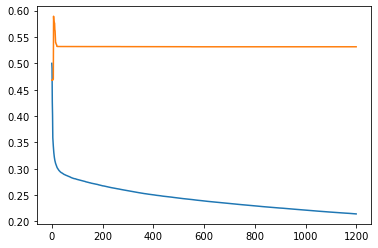

In [10]:
plot_error_curves(evals_result)

The previous results demonstrate the performance of XGBoost using the non-normalised non-standardised data. The model scored an accuracy of 46.8% which is a very low score. Furthermore, upon analysing the loss curves, the evaluation loss seemed to increase in the beginning of training then remained constant for the rest of the training phase. The training loss, on the other hand, remained a decreasing trend throughout training. This suggests overfitting of the model.

Next, the classifier is trained on the normalised standardised datasets.

In [11]:
bst, evals_result, acc, best_params = train(data=X_train, label=y_train)

###############
{'tree_method': 'gpu_hist', 'objective': 'binary:hinge', 'booster': 'gbtree', 'max_depth': 3}
---------------
[0]	train-error:0.50000	eval-error:0.46806
[1]	train-error:0.50000	eval-error:0.46806
[2]	train-error:0.50000	eval-error:0.46806
[3]	train-error:0.43941	eval-error:0.41566
[4]	train-error:0.43941	eval-error:0.41566
[5]	train-error:0.43941	eval-error:0.41566
[6]	train-error:0.38704	eval-error:0.37376
[7]	train-error:0.37983	eval-error:0.37051
[8]	train-error:0.37292	eval-error:0.36532
[9]	train-error:0.37326	eval-error:0.36639
[10]	train-error:0.37326	eval-error:0.36639
[11]	train-error:0.37326	eval-error:0.36639
[12]	train-error:0.37337	eval-error:0.36631
[13]	train-error:0.37326	eval-error:0.36639
[14]	train-error:0.37306	eval-error:0.36619
[15]	train-error:0.36844	eval-error:0.36229
[16]	train-error:0.36836	eval-error:0.36225
[17]	train-error:0.36834	eval-error:0.36224
[18]	train-error:0.36787	eval-error:0.36183
[19]	train-error:0.36741	eval-error:0.36141
[20]

[182]	train-error:0.32325	eval-error:0.32225
[183]	train-error:0.32311	eval-error:0.32215
[184]	train-error:0.32306	eval-error:0.32207
[185]	train-error:0.32303	eval-error:0.32202
[186]	train-error:0.32299	eval-error:0.32199
[187]	train-error:0.32285	eval-error:0.32184
[188]	train-error:0.32273	eval-error:0.32170
[189]	train-error:0.32267	eval-error:0.32167
[190]	train-error:0.32258	eval-error:0.32160
[191]	train-error:0.32246	eval-error:0.32153
[192]	train-error:0.32234	eval-error:0.32137
[193]	train-error:0.32221	eval-error:0.32127
[194]	train-error:0.32200	eval-error:0.32103
[195]	train-error:0.32177	eval-error:0.32095
[196]	train-error:0.32157	eval-error:0.32083
[197]	train-error:0.32139	eval-error:0.32060
[198]	train-error:0.32126	eval-error:0.32051
[199]	train-error:0.32111	eval-error:0.32040
[200]	train-error:0.32103	eval-error:0.32034
[201]	train-error:0.32096	eval-error:0.32028
[202]	train-error:0.32091	eval-error:0.32019
[203]	train-error:0.32082	eval-error:0.32013
[204]	trai

[365]	train-error:0.30861	eval-error:0.30913
[366]	train-error:0.30860	eval-error:0.30911
[367]	train-error:0.30850	eval-error:0.30905
[368]	train-error:0.30849	eval-error:0.30903
[369]	train-error:0.30848	eval-error:0.30898
[370]	train-error:0.30846	eval-error:0.30897
[371]	train-error:0.30844	eval-error:0.30897
[372]	train-error:0.30839	eval-error:0.30894
[373]	train-error:0.30828	eval-error:0.30882
[374]	train-error:0.30824	eval-error:0.30878
[375]	train-error:0.30821	eval-error:0.30890
[376]	train-error:0.30819	eval-error:0.30887
[377]	train-error:0.30811	eval-error:0.30880
[378]	train-error:0.30809	eval-error:0.30874
[379]	train-error:0.30804	eval-error:0.30870
[380]	train-error:0.30793	eval-error:0.30864
[381]	train-error:0.30773	eval-error:0.30843
[382]	train-error:0.30763	eval-error:0.30833
[383]	train-error:0.30757	eval-error:0.30828
[384]	train-error:0.30751	eval-error:0.30823
[385]	train-error:0.30745	eval-error:0.30817
[386]	train-error:0.30742	eval-error:0.30813
[387]	trai

[548]	train-error:0.30106	eval-error:0.30291
[549]	train-error:0.30103	eval-error:0.30288
[550]	train-error:0.30104	eval-error:0.30290
[551]	train-error:0.30099	eval-error:0.30288
[552]	train-error:0.30097	eval-error:0.30285
[553]	train-error:0.30092	eval-error:0.30280
[554]	train-error:0.30092	eval-error:0.30278
[555]	train-error:0.30091	eval-error:0.30279
[556]	train-error:0.30091	eval-error:0.30281
[557]	train-error:0.30084	eval-error:0.30270
[558]	train-error:0.30081	eval-error:0.30269
[559]	train-error:0.30081	eval-error:0.30268
[560]	train-error:0.30080	eval-error:0.30268
[561]	train-error:0.30079	eval-error:0.30264
[562]	train-error:0.30077	eval-error:0.30260
[563]	train-error:0.30072	eval-error:0.30260
[564]	train-error:0.30069	eval-error:0.30262
[565]	train-error:0.30069	eval-error:0.30258
[566]	train-error:0.30069	eval-error:0.30256
[567]	train-error:0.30065	eval-error:0.30251
[568]	train-error:0.30062	eval-error:0.30246
[569]	train-error:0.30057	eval-error:0.30244
[570]	trai

[731]	train-error:0.29729	eval-error:0.29959
[732]	train-error:0.29727	eval-error:0.29957
[733]	train-error:0.29726	eval-error:0.29958
[734]	train-error:0.29721	eval-error:0.29954
[735]	train-error:0.29718	eval-error:0.29951
[736]	train-error:0.29715	eval-error:0.29943
[737]	train-error:0.29713	eval-error:0.29942
[738]	train-error:0.29711	eval-error:0.29945
[739]	train-error:0.29711	eval-error:0.29944
[740]	train-error:0.29711	eval-error:0.29941
[741]	train-error:0.29708	eval-error:0.29940
[742]	train-error:0.29707	eval-error:0.29936
[743]	train-error:0.29705	eval-error:0.29935
[744]	train-error:0.29704	eval-error:0.29935
[745]	train-error:0.29704	eval-error:0.29932
[746]	train-error:0.29703	eval-error:0.29934
[747]	train-error:0.29702	eval-error:0.29933
[748]	train-error:0.29698	eval-error:0.29929
[749]	train-error:0.29694	eval-error:0.29930
[750]	train-error:0.29691	eval-error:0.29926
[751]	train-error:0.29691	eval-error:0.29930
[752]	train-error:0.29691	eval-error:0.29929
[753]	trai

[914]	train-error:0.29381	eval-error:0.29649
[915]	train-error:0.29379	eval-error:0.29643
[916]	train-error:0.29379	eval-error:0.29643
[917]	train-error:0.29378	eval-error:0.29644
[918]	train-error:0.29376	eval-error:0.29640
[919]	train-error:0.29372	eval-error:0.29630
[920]	train-error:0.29372	eval-error:0.29634
[921]	train-error:0.29372	eval-error:0.29631
[922]	train-error:0.29370	eval-error:0.29636
[923]	train-error:0.29369	eval-error:0.29631
[924]	train-error:0.29365	eval-error:0.29626
[925]	train-error:0.29362	eval-error:0.29623
[926]	train-error:0.29357	eval-error:0.29614
[927]	train-error:0.29354	eval-error:0.29605
[928]	train-error:0.29352	eval-error:0.29605
[929]	train-error:0.29350	eval-error:0.29608
[930]	train-error:0.29350	eval-error:0.29604
[931]	train-error:0.29349	eval-error:0.29603
[932]	train-error:0.29346	eval-error:0.29601
[933]	train-error:0.29345	eval-error:0.29598
[934]	train-error:0.29345	eval-error:0.29600
[935]	train-error:0.29342	eval-error:0.29597
[936]	trai

[1094]	train-error:0.29114	eval-error:0.29388
[1095]	train-error:0.29112	eval-error:0.29384
[1096]	train-error:0.29110	eval-error:0.29383
[1097]	train-error:0.29108	eval-error:0.29382
[1098]	train-error:0.29107	eval-error:0.29379
[1099]	train-error:0.29103	eval-error:0.29380
[1100]	train-error:0.29101	eval-error:0.29380
[1101]	train-error:0.29098	eval-error:0.29376
[1102]	train-error:0.29094	eval-error:0.29375
[1103]	train-error:0.29093	eval-error:0.29378
[1104]	train-error:0.29092	eval-error:0.29374
[1105]	train-error:0.29092	eval-error:0.29376
[1106]	train-error:0.29091	eval-error:0.29378
[1107]	train-error:0.29090	eval-error:0.29377
[1108]	train-error:0.29089	eval-error:0.29379
[1109]	train-error:0.29086	eval-error:0.29374
[1110]	train-error:0.29081	eval-error:0.29375
[1111]	train-error:0.29081	eval-error:0.29374
[1112]	train-error:0.29081	eval-error:0.29369
[1113]	train-error:0.29077	eval-error:0.29367
[1114]	train-error:0.29076	eval-error:0.29364
[1115]	train-error:0.29074	eval-er

[73]	train-error:0.30960	eval-error:0.30843
[74]	train-error:0.30942	eval-error:0.30823
[75]	train-error:0.30918	eval-error:0.30797
[76]	train-error:0.30887	eval-error:0.30773
[77]	train-error:0.30855	eval-error:0.30743
[78]	train-error:0.30830	eval-error:0.30725
[79]	train-error:0.30818	eval-error:0.30712
[80]	train-error:0.30795	eval-error:0.30696
[81]	train-error:0.30775	eval-error:0.30683
[82]	train-error:0.30742	eval-error:0.30662
[83]	train-error:0.30721	eval-error:0.30646
[84]	train-error:0.30689	eval-error:0.30624
[85]	train-error:0.30658	eval-error:0.30599
[86]	train-error:0.30634	eval-error:0.30576
[87]	train-error:0.30617	eval-error:0.30554
[88]	train-error:0.30601	eval-error:0.30543
[89]	train-error:0.30580	eval-error:0.30520
[90]	train-error:0.30566	eval-error:0.30522
[91]	train-error:0.30545	eval-error:0.30508
[92]	train-error:0.30533	eval-error:0.30493
[93]	train-error:0.30524	eval-error:0.30487
[94]	train-error:0.30514	eval-error:0.30475
[95]	train-error:0.30509	eval-er

[256]	train-error:0.29057	eval-error:0.29275
[257]	train-error:0.29050	eval-error:0.29268
[258]	train-error:0.29043	eval-error:0.29257
[259]	train-error:0.29032	eval-error:0.29252
[260]	train-error:0.29026	eval-error:0.29247
[261]	train-error:0.29017	eval-error:0.29241
[262]	train-error:0.29006	eval-error:0.29233
[263]	train-error:0.28994	eval-error:0.29217
[264]	train-error:0.28990	eval-error:0.29218
[265]	train-error:0.28986	eval-error:0.29216
[266]	train-error:0.28984	eval-error:0.29214
[267]	train-error:0.28974	eval-error:0.29194
[268]	train-error:0.28968	eval-error:0.29184
[269]	train-error:0.28963	eval-error:0.29186
[270]	train-error:0.28955	eval-error:0.29183
[271]	train-error:0.28952	eval-error:0.29179
[272]	train-error:0.28943	eval-error:0.29170
[273]	train-error:0.28930	eval-error:0.29163
[274]	train-error:0.28924	eval-error:0.29153
[275]	train-error:0.28919	eval-error:0.29148
[276]	train-error:0.28913	eval-error:0.29145
[277]	train-error:0.28905	eval-error:0.29135
[278]	trai

[439]	train-error:0.28177	eval-error:0.28559
[440]	train-error:0.28170	eval-error:0.28547
[441]	train-error:0.28169	eval-error:0.28544
[442]	train-error:0.28165	eval-error:0.28543
[443]	train-error:0.28161	eval-error:0.28544
[444]	train-error:0.28154	eval-error:0.28538
[445]	train-error:0.28152	eval-error:0.28540
[446]	train-error:0.28151	eval-error:0.28545
[447]	train-error:0.28148	eval-error:0.28542
[448]	train-error:0.28147	eval-error:0.28539
[449]	train-error:0.28145	eval-error:0.28534
[450]	train-error:0.28141	eval-error:0.28527
[451]	train-error:0.28139	eval-error:0.28526
[452]	train-error:0.28138	eval-error:0.28521
[453]	train-error:0.28137	eval-error:0.28521
[454]	train-error:0.28136	eval-error:0.28520
[455]	train-error:0.28130	eval-error:0.28517
[456]	train-error:0.28128	eval-error:0.28516
[457]	train-error:0.28128	eval-error:0.28515
[458]	train-error:0.28123	eval-error:0.28514
[459]	train-error:0.28119	eval-error:0.28510
[460]	train-error:0.28114	eval-error:0.28502
[461]	trai

[622]	train-error:0.27648	eval-error:0.28106
[623]	train-error:0.27646	eval-error:0.28105
[624]	train-error:0.27642	eval-error:0.28103
[625]	train-error:0.27639	eval-error:0.28099
[626]	train-error:0.27638	eval-error:0.28103
[627]	train-error:0.27636	eval-error:0.28100
[628]	train-error:0.27635	eval-error:0.28100
[629]	train-error:0.27631	eval-error:0.28094
[630]	train-error:0.27630	eval-error:0.28096
[631]	train-error:0.27630	eval-error:0.28096
[632]	train-error:0.27626	eval-error:0.28092
[633]	train-error:0.27626	eval-error:0.28090
[634]	train-error:0.27625	eval-error:0.28089
[635]	train-error:0.27621	eval-error:0.28094
[636]	train-error:0.27616	eval-error:0.28091
[637]	train-error:0.27615	eval-error:0.28086
[638]	train-error:0.27614	eval-error:0.28083
[639]	train-error:0.27611	eval-error:0.28077
[640]	train-error:0.27611	eval-error:0.28076
[641]	train-error:0.27610	eval-error:0.28076
[642]	train-error:0.27608	eval-error:0.28079
[643]	train-error:0.27606	eval-error:0.28077
[644]	trai

[805]	train-error:0.27234	eval-error:0.27783
[806]	train-error:0.27233	eval-error:0.27777
[807]	train-error:0.27233	eval-error:0.27777
[808]	train-error:0.27230	eval-error:0.27775
[809]	train-error:0.27228	eval-error:0.27770
[810]	train-error:0.27227	eval-error:0.27767
[811]	train-error:0.27224	eval-error:0.27764
[812]	train-error:0.27222	eval-error:0.27761
[813]	train-error:0.27220	eval-error:0.27763
[814]	train-error:0.27217	eval-error:0.27767
[815]	train-error:0.27215	eval-error:0.27762
[816]	train-error:0.27212	eval-error:0.27756
[817]	train-error:0.27211	eval-error:0.27753
[818]	train-error:0.27208	eval-error:0.27754
[819]	train-error:0.27206	eval-error:0.27756
[820]	train-error:0.27205	eval-error:0.27757
[821]	train-error:0.27205	eval-error:0.27756
[822]	train-error:0.27204	eval-error:0.27755
[823]	train-error:0.27204	eval-error:0.27752
[824]	train-error:0.27200	eval-error:0.27751
[825]	train-error:0.27198	eval-error:0.27751
[826]	train-error:0.27194	eval-error:0.27746
[827]	trai

[988]	train-error:0.26923	eval-error:0.27558
[989]	train-error:0.26922	eval-error:0.27560
[990]	train-error:0.26918	eval-error:0.27556
[991]	train-error:0.26916	eval-error:0.27552
[992]	train-error:0.26916	eval-error:0.27550
[993]	train-error:0.26914	eval-error:0.27551
[994]	train-error:0.26912	eval-error:0.27551
[995]	train-error:0.26911	eval-error:0.27543
[996]	train-error:0.26910	eval-error:0.27542
[997]	train-error:0.26909	eval-error:0.27543
[998]	train-error:0.26909	eval-error:0.27539
[999]	train-error:0.26906	eval-error:0.27537
[1000]	train-error:0.26905	eval-error:0.27536
[1001]	train-error:0.26903	eval-error:0.27538
[1002]	train-error:0.26903	eval-error:0.27538
[1003]	train-error:0.26902	eval-error:0.27541
[1004]	train-error:0.26900	eval-error:0.27541
[1005]	train-error:0.26898	eval-error:0.27536
[1006]	train-error:0.26897	eval-error:0.27532
[1007]	train-error:0.26895	eval-error:0.27534
[1008]	train-error:0.26892	eval-error:0.27533
[1009]	train-error:0.26890	eval-error:0.27533


[1167]	train-error:0.26677	eval-error:0.27362
[1168]	train-error:0.26675	eval-error:0.27363
[1169]	train-error:0.26674	eval-error:0.27363
[1170]	train-error:0.26672	eval-error:0.27360
[1171]	train-error:0.26670	eval-error:0.27356
[1172]	train-error:0.26668	eval-error:0.27352
[1173]	train-error:0.26668	eval-error:0.27351
[1174]	train-error:0.26665	eval-error:0.27348
[1175]	train-error:0.26664	eval-error:0.27350
[1176]	train-error:0.26663	eval-error:0.27350
[1177]	train-error:0.26661	eval-error:0.27348
[1178]	train-error:0.26656	eval-error:0.27344
[1179]	train-error:0.26655	eval-error:0.27344
[1180]	train-error:0.26654	eval-error:0.27345
[1181]	train-error:0.26654	eval-error:0.27345
[1182]	train-error:0.26654	eval-error:0.27350
[1183]	train-error:0.26653	eval-error:0.27349
[1184]	train-error:0.26653	eval-error:0.27349
[1185]	train-error:0.26651	eval-error:0.27347
[1186]	train-error:0.26651	eval-error:0.27350
[1187]	train-error:0.26648	eval-error:0.27352
[1188]	train-error:0.26647	eval-er

[148]	train-error:0.28441	eval-error:0.28798
[149]	train-error:0.28435	eval-error:0.28794
[150]	train-error:0.28424	eval-error:0.28783
[151]	train-error:0.28417	eval-error:0.28781
[152]	train-error:0.28411	eval-error:0.28775
[153]	train-error:0.28400	eval-error:0.28773
[154]	train-error:0.28383	eval-error:0.28756
[155]	train-error:0.28371	eval-error:0.28758
[156]	train-error:0.28363	eval-error:0.28749
[157]	train-error:0.28357	eval-error:0.28748
[158]	train-error:0.28347	eval-error:0.28742
[159]	train-error:0.28336	eval-error:0.28731
[160]	train-error:0.28332	eval-error:0.28731
[161]	train-error:0.28322	eval-error:0.28714
[162]	train-error:0.28314	eval-error:0.28708
[163]	train-error:0.28309	eval-error:0.28701
[164]	train-error:0.28305	eval-error:0.28706
[165]	train-error:0.28300	eval-error:0.28703
[166]	train-error:0.28284	eval-error:0.28695
[167]	train-error:0.28267	eval-error:0.28687
[168]	train-error:0.28256	eval-error:0.28679
[169]	train-error:0.28236	eval-error:0.28653
[170]	trai

[331]	train-error:0.26946	eval-error:0.27695
[332]	train-error:0.26939	eval-error:0.27692
[333]	train-error:0.26932	eval-error:0.27690
[334]	train-error:0.26927	eval-error:0.27683
[335]	train-error:0.26920	eval-error:0.27678
[336]	train-error:0.26914	eval-error:0.27679
[337]	train-error:0.26911	eval-error:0.27679
[338]	train-error:0.26906	eval-error:0.27675
[339]	train-error:0.26902	eval-error:0.27670
[340]	train-error:0.26899	eval-error:0.27668
[341]	train-error:0.26895	eval-error:0.27668
[342]	train-error:0.26892	eval-error:0.27669
[343]	train-error:0.26887	eval-error:0.27663
[344]	train-error:0.26879	eval-error:0.27658
[345]	train-error:0.26877	eval-error:0.27658
[346]	train-error:0.26875	eval-error:0.27655
[347]	train-error:0.26861	eval-error:0.27650
[348]	train-error:0.26856	eval-error:0.27645
[349]	train-error:0.26850	eval-error:0.27629
[350]	train-error:0.26843	eval-error:0.27631
[351]	train-error:0.26832	eval-error:0.27624
[352]	train-error:0.26824	eval-error:0.27624
[353]	trai

[514]	train-error:0.26043	eval-error:0.27162
[515]	train-error:0.26039	eval-error:0.27160
[516]	train-error:0.26034	eval-error:0.27158
[517]	train-error:0.26030	eval-error:0.27158
[518]	train-error:0.26025	eval-error:0.27159
[519]	train-error:0.26019	eval-error:0.27157
[520]	train-error:0.26016	eval-error:0.27158
[521]	train-error:0.26013	eval-error:0.27156
[522]	train-error:0.26006	eval-error:0.27155
[523]	train-error:0.26000	eval-error:0.27148
[524]	train-error:0.25997	eval-error:0.27150
[525]	train-error:0.25993	eval-error:0.27142
[526]	train-error:0.25988	eval-error:0.27142
[527]	train-error:0.25981	eval-error:0.27139
[528]	train-error:0.25976	eval-error:0.27134
[529]	train-error:0.25973	eval-error:0.27132
[530]	train-error:0.25969	eval-error:0.27129
[531]	train-error:0.25968	eval-error:0.27127
[532]	train-error:0.25961	eval-error:0.27130
[533]	train-error:0.25958	eval-error:0.27125
[534]	train-error:0.25955	eval-error:0.27125
[535]	train-error:0.25951	eval-error:0.27122
[536]	trai

[697]	train-error:0.25348	eval-error:0.26850
[698]	train-error:0.25346	eval-error:0.26852
[699]	train-error:0.25343	eval-error:0.26851
[700]	train-error:0.25341	eval-error:0.26853
[701]	train-error:0.25338	eval-error:0.26852
[702]	train-error:0.25336	eval-error:0.26845
[703]	train-error:0.25332	eval-error:0.26844
[704]	train-error:0.25328	eval-error:0.26841
[705]	train-error:0.25325	eval-error:0.26838
[706]	train-error:0.25320	eval-error:0.26836
[707]	train-error:0.25317	eval-error:0.26839
[708]	train-error:0.25315	eval-error:0.26842
[709]	train-error:0.25310	eval-error:0.26839
[710]	train-error:0.25305	eval-error:0.26834
[711]	train-error:0.25303	eval-error:0.26832
[712]	train-error:0.25301	eval-error:0.26828
[713]	train-error:0.25301	eval-error:0.26832
[714]	train-error:0.25299	eval-error:0.26827
[715]	train-error:0.25297	eval-error:0.26819
[716]	train-error:0.25291	eval-error:0.26816
[717]	train-error:0.25289	eval-error:0.26819
[718]	train-error:0.25284	eval-error:0.26825
[719]	trai

[880]	train-error:0.24807	eval-error:0.26662
[881]	train-error:0.24805	eval-error:0.26660
[882]	train-error:0.24803	eval-error:0.26663
[883]	train-error:0.24801	eval-error:0.26660
[884]	train-error:0.24796	eval-error:0.26661
[885]	train-error:0.24794	eval-error:0.26660
[886]	train-error:0.24793	eval-error:0.26658
[887]	train-error:0.24789	eval-error:0.26661
[888]	train-error:0.24786	eval-error:0.26660
[889]	train-error:0.24782	eval-error:0.26660
[890]	train-error:0.24780	eval-error:0.26661
[891]	train-error:0.24778	eval-error:0.26662
[892]	train-error:0.24775	eval-error:0.26663
[893]	train-error:0.24772	eval-error:0.26665
[894]	train-error:0.24773	eval-error:0.26664
[895]	train-error:0.24769	eval-error:0.26659
[896]	train-error:0.24767	eval-error:0.26658
[897]	train-error:0.24765	eval-error:0.26656
[898]	train-error:0.24762	eval-error:0.26655
[899]	train-error:0.24759	eval-error:0.26652
[900]	train-error:0.24753	eval-error:0.26651
[901]	train-error:0.24752	eval-error:0.26643
[902]	trai

[1061]	train-error:0.24298	eval-error:0.26488
[1062]	train-error:0.24294	eval-error:0.26492
[1063]	train-error:0.24292	eval-error:0.26490
[1064]	train-error:0.24288	eval-error:0.26495
[1065]	train-error:0.24286	eval-error:0.26489
[1066]	train-error:0.24283	eval-error:0.26493
[1067]	train-error:0.24281	eval-error:0.26493
[1068]	train-error:0.24278	eval-error:0.26490
[1069]	train-error:0.24275	eval-error:0.26494
[1070]	train-error:0.24273	eval-error:0.26495
[1071]	train-error:0.24269	eval-error:0.26487
[1072]	train-error:0.24266	eval-error:0.26489
[1073]	train-error:0.24264	eval-error:0.26489
[1074]	train-error:0.24262	eval-error:0.26496
[1075]	train-error:0.24260	eval-error:0.26498
[1076]	train-error:0.24257	eval-error:0.26493
[1077]	train-error:0.24253	eval-error:0.26488
[1078]	train-error:0.24250	eval-error:0.26488
[1079]	train-error:0.24248	eval-error:0.26487
[1080]	train-error:0.24245	eval-error:0.26490
[1081]	train-error:0.24242	eval-error:0.26490
[1082]	train-error:0.24237	eval-er

[39]	train-error:0.29840	eval-error:0.29834
[40]	train-error:0.29801	eval-error:0.29805
[41]	train-error:0.29765	eval-error:0.29778
[42]	train-error:0.29728	eval-error:0.29754
[43]	train-error:0.29682	eval-error:0.29712
[44]	train-error:0.29650	eval-error:0.29686
[45]	train-error:0.29620	eval-error:0.29668
[46]	train-error:0.29602	eval-error:0.29660
[47]	train-error:0.29564	eval-error:0.29635
[48]	train-error:0.29517	eval-error:0.29602
[49]	train-error:0.29492	eval-error:0.29575
[50]	train-error:0.29459	eval-error:0.29556
[51]	train-error:0.29424	eval-error:0.29529
[52]	train-error:0.29384	eval-error:0.29506
[53]	train-error:0.29349	eval-error:0.29471
[54]	train-error:0.29318	eval-error:0.29453
[55]	train-error:0.29309	eval-error:0.29445
[56]	train-error:0.29285	eval-error:0.29430
[57]	train-error:0.29267	eval-error:0.29416
[58]	train-error:0.29237	eval-error:0.29397
[59]	train-error:0.29225	eval-error:0.29392
[60]	train-error:0.29217	eval-error:0.29393
[61]	train-error:0.29199	eval-er

[223]	train-error:0.26869	eval-error:0.27831
[224]	train-error:0.26853	eval-error:0.27817
[225]	train-error:0.26829	eval-error:0.27796
[226]	train-error:0.26820	eval-error:0.27794
[227]	train-error:0.26808	eval-error:0.27786
[228]	train-error:0.26799	eval-error:0.27777
[229]	train-error:0.26787	eval-error:0.27765
[230]	train-error:0.26775	eval-error:0.27757
[231]	train-error:0.26768	eval-error:0.27749
[232]	train-error:0.26758	eval-error:0.27747
[233]	train-error:0.26749	eval-error:0.27744
[234]	train-error:0.26743	eval-error:0.27742
[235]	train-error:0.26735	eval-error:0.27735
[236]	train-error:0.26725	eval-error:0.27732
[237]	train-error:0.26715	eval-error:0.27721
[238]	train-error:0.26704	eval-error:0.27707
[239]	train-error:0.26692	eval-error:0.27696
[240]	train-error:0.26683	eval-error:0.27697
[241]	train-error:0.26673	eval-error:0.27697
[242]	train-error:0.26664	eval-error:0.27688
[243]	train-error:0.26652	eval-error:0.27679
[244]	train-error:0.26642	eval-error:0.27687
[245]	trai

[406]	train-error:0.25378	eval-error:0.27027
[407]	train-error:0.25371	eval-error:0.27022
[408]	train-error:0.25362	eval-error:0.27022
[409]	train-error:0.25352	eval-error:0.27020
[410]	train-error:0.25341	eval-error:0.27017
[411]	train-error:0.25336	eval-error:0.27011
[412]	train-error:0.25328	eval-error:0.27015
[413]	train-error:0.25322	eval-error:0.27009
[414]	train-error:0.25315	eval-error:0.27004
[415]	train-error:0.25308	eval-error:0.27003
[416]	train-error:0.25304	eval-error:0.26997
[417]	train-error:0.25300	eval-error:0.27000
[418]	train-error:0.25293	eval-error:0.26990
[419]	train-error:0.25280	eval-error:0.26986
[420]	train-error:0.25271	eval-error:0.26986
[421]	train-error:0.25265	eval-error:0.26985
[422]	train-error:0.25259	eval-error:0.26986
[423]	train-error:0.25254	eval-error:0.26989
[424]	train-error:0.25247	eval-error:0.26991
[425]	train-error:0.25243	eval-error:0.26988
[426]	train-error:0.25240	eval-error:0.26986
[427]	train-error:0.25235	eval-error:0.26985
[428]	trai

[589]	train-error:0.24283	eval-error:0.26614
[590]	train-error:0.24275	eval-error:0.26613
[591]	train-error:0.24268	eval-error:0.26611
[592]	train-error:0.24263	eval-error:0.26606
[593]	train-error:0.24259	eval-error:0.26606
[594]	train-error:0.24253	eval-error:0.26606
[595]	train-error:0.24247	eval-error:0.26603
[596]	train-error:0.24243	eval-error:0.26607
[597]	train-error:0.24237	eval-error:0.26601
[598]	train-error:0.24232	eval-error:0.26600
[599]	train-error:0.24227	eval-error:0.26598
[600]	train-error:0.24223	eval-error:0.26601
[601]	train-error:0.24217	eval-error:0.26598
[602]	train-error:0.24212	eval-error:0.26596
[603]	train-error:0.24204	eval-error:0.26599
[604]	train-error:0.24199	eval-error:0.26594
[605]	train-error:0.24194	eval-error:0.26596
[606]	train-error:0.24188	eval-error:0.26592
[607]	train-error:0.24185	eval-error:0.26593
[608]	train-error:0.24181	eval-error:0.26597
[609]	train-error:0.24174	eval-error:0.26596
[610]	train-error:0.24166	eval-error:0.26592
[611]	trai

[772]	train-error:0.23353	eval-error:0.26392
[773]	train-error:0.23348	eval-error:0.26389
[774]	train-error:0.23344	eval-error:0.26388
[775]	train-error:0.23341	eval-error:0.26385
[776]	train-error:0.23335	eval-error:0.26386
[777]	train-error:0.23331	eval-error:0.26388
[778]	train-error:0.23326	eval-error:0.26388
[779]	train-error:0.23323	eval-error:0.26383
[780]	train-error:0.23315	eval-error:0.26382
[781]	train-error:0.23310	eval-error:0.26380
[782]	train-error:0.23306	eval-error:0.26375
[783]	train-error:0.23302	eval-error:0.26375
[784]	train-error:0.23294	eval-error:0.26372
[785]	train-error:0.23291	eval-error:0.26371
[786]	train-error:0.23288	eval-error:0.26371
[787]	train-error:0.23283	eval-error:0.26371
[788]	train-error:0.23278	eval-error:0.26370
[789]	train-error:0.23273	eval-error:0.26373
[790]	train-error:0.23267	eval-error:0.26369
[791]	train-error:0.23262	eval-error:0.26370
[792]	train-error:0.23259	eval-error:0.26372
[793]	train-error:0.23254	eval-error:0.26375
[794]	trai

[955]	train-error:0.22546	eval-error:0.26252
[956]	train-error:0.22540	eval-error:0.26256
[957]	train-error:0.22536	eval-error:0.26258
[958]	train-error:0.22532	eval-error:0.26259
[959]	train-error:0.22527	eval-error:0.26257
[960]	train-error:0.22522	eval-error:0.26253
[961]	train-error:0.22517	eval-error:0.26256
[962]	train-error:0.22515	eval-error:0.26260
[963]	train-error:0.22513	eval-error:0.26261
[964]	train-error:0.22509	eval-error:0.26266
[965]	train-error:0.22506	eval-error:0.26264
[966]	train-error:0.22502	eval-error:0.26264
[967]	train-error:0.22498	eval-error:0.26265
[968]	train-error:0.22493	eval-error:0.26269
[969]	train-error:0.22490	eval-error:0.26261
[970]	train-error:0.22485	eval-error:0.26261
[971]	train-error:0.22481	eval-error:0.26264
[972]	train-error:0.22478	eval-error:0.26262
[973]	train-error:0.22472	eval-error:0.26265
[974]	train-error:0.22469	eval-error:0.26261
[975]	train-error:0.22467	eval-error:0.26261
[976]	train-error:0.22464	eval-error:0.26260
[977]	trai

[1135]	train-error:0.21846	eval-error:0.26176
[1136]	train-error:0.21843	eval-error:0.26174
[1137]	train-error:0.21839	eval-error:0.26173
[1138]	train-error:0.21835	eval-error:0.26170
[1139]	train-error:0.21832	eval-error:0.26169
[1140]	train-error:0.21825	eval-error:0.26170
[1141]	train-error:0.21818	eval-error:0.26172
[1142]	train-error:0.21816	eval-error:0.26167
[1143]	train-error:0.21813	eval-error:0.26166
[1144]	train-error:0.21810	eval-error:0.26168
[1145]	train-error:0.21806	eval-error:0.26173
[1146]	train-error:0.21802	eval-error:0.26170
[1147]	train-error:0.21798	eval-error:0.26169
[1148]	train-error:0.21796	eval-error:0.26170
[1149]	train-error:0.21793	eval-error:0.26167
[1150]	train-error:0.21787	eval-error:0.26167
[1151]	train-error:0.21781	eval-error:0.26165
[1152]	train-error:0.21778	eval-error:0.26166
[1153]	train-error:0.21770	eval-error:0.26162
[1154]	train-error:0.21766	eval-error:0.26158
[1155]	train-error:0.21763	eval-error:0.26154
[1156]	train-error:0.21760	eval-er

In [12]:
print('best achieved accuracy: {}%'.format(round(acc * 100, 2)))
print('parameters:', best_params)

best achieved accuracy: 73.84%
parameters: {'tree_method': 'gpu_hist', 'objective': 'binary:hinge', 'booster': 'gbtree', 'max_depth': 8}


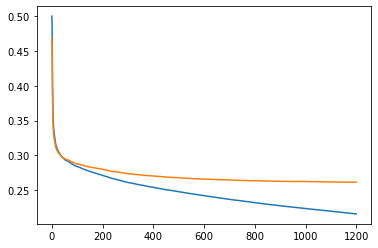

In [13]:
plot_error_curves(evals_result)

The previous results demonstrate the performance of XGBoost using the normalised standardised data. It is immediately clear that this version of the model is superior to the previous one. The model achieved an accuracy of 74% on the validation set. The loss curves show both training and validation losses decreasing throught the training phase. The decrease in the validation loss appear to slow down after the 800 epoch then remain almost constant after the 1000th epoch.

In [14]:
dval = xgb.DMatrix(data=X_val)
y_pred = bst.predict(dval).astype(int)

              precision    recall  f1-score   support

           0       0.71      0.74      0.73    305879
           1       0.76      0.74      0.75    347624

    accuracy                           0.74    653503
   macro avg       0.74      0.74      0.74    653503
weighted avg       0.74      0.74      0.74    653503

Sensitivity:  0.74
Specificity:  0.74


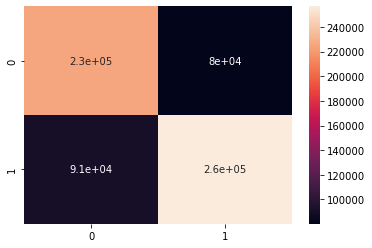

In [15]:
report(y_val['process'].to_cupy(), cp.array(y_pred))

After evaluating the final model on the validation set, the model achieved validation accuracy of 74% with 74% precision and recall. This is the best result achieved among the three trained classifiers so far.

In [16]:
bst.save_model("./saved_model/xgb.v1.model")

In [17]:
bst = xgb.Booster()
bst.load_model('./saved_model/xgb.v1.model')

---
## 2.2. PCA

The best achieved accuracy across all models was 74%, which is a satisfactory result considering the complexity of the problem at hand. However, further experiments may help to improve the accuracy. One such experiment could be to apply PCA to the data to see if it helps to improve the accuracy of the models. PCA is a popular technique for reducing the dimensionality of large datasets, which can often lead to better performance and faster computation times. By reducing the number of features in the dataset, it may be possible to uncover hidden patterns and relationships that were previously obscured. Therefore, applying PCA to the data is definitely a worthwhile experiment to undertake in order to improve the performance of the models.

cuML offers an accelerated implementation of PCA which will be used for this task.

In [10]:
from cuml import PCA

pca = PCA(n_components = 21)
pca.fit(X_train)

PCA()

In [11]:
pca_train = pca.transform(X_train)
pca_val = pca.transform(X_val)
pca_test = pca.transform(X_test)

The same grid search functions used above will be used again with the new resulted data.

In [12]:
_cLR, best_params, acc = cLR_grid_search(['l1', 'l2'], [50, 75, 100, 150], X_train=pca_train, X_val=pca_val)
'New accuracy with logistic regression: {}'.format(acc)

penalty: l1, linesearch_max_iter: 50 ==> val accuracy =  56.57
penalty: l1, linesearch_max_iter: 75 ==> val accuracy =  56.57
penalty: l1, linesearch_max_iter: 100 ==> val accuracy =  56.57
penalty: l1, linesearch_max_iter: 150 ==> val accuracy =  56.57
penalty: l2, linesearch_max_iter: 50 ==> val accuracy =  56.56
penalty: l2, linesearch_max_iter: 75 ==> val accuracy =  56.56
penalty: l2, linesearch_max_iter: 100 ==> val accuracy =  56.56
penalty: l2, linesearch_max_iter: 150 ==> val accuracy =  56.56
Time passed: 1.48 seconds.


'New accuracy with logistic regression: 56.57'

In [13]:
max_depths = [10, 30, 50]
n_estimators = [25, 45]
_cRF, best_params, acc = crf_grid_search(max_depths, n_estimators, X_train=pca_train, X_val=pca_val)
'New accuracy with random forest: {}'.format(acc)

max_depth: 10, n_estimators: 25 ==> val accuracy =  63.31
max_depth: 10, n_estimators: 45 ==> val accuracy =  63.61
max_depth: 30, n_estimators: 25 ==> val accuracy =  68.31
max_depth: 30, n_estimators: 45 ==> val accuracy =  69.09
max_depth: 50, n_estimators: 25 ==> val accuracy =  68.08
max_depth: 50, n_estimators: 45 ==> val accuracy =  69.05


'New accuracy with random forest: 69.09'

In [14]:
_bst, evals_result, acc, best_params = train(data=X_train_resampled, label=y_train_resampled)

###############
{'tree_method': 'gpu_hist', 'objective': 'binary:hinge', 'booster': 'gbtree', 'max_depth': 3}
---------------
[0]	train-error:0.50000	eval-error:0.46806
[1]	train-error:0.50000	eval-error:0.46806
[2]	train-error:0.45811	eval-error:0.46806
[3]	train-error:0.45811	eval-error:0.46806
[4]	train-error:0.43296	eval-error:0.46806
[5]	train-error:0.38455	eval-error:0.46807
[6]	train-error:0.38173	eval-error:0.46807
[7]	train-error:0.38032	eval-error:0.46807
[8]	train-error:0.38008	eval-error:0.46807
[9]	train-error:0.37989	eval-error:0.46807
[10]	train-error:0.37607	eval-error:0.46807
[11]	train-error:0.35724	eval-error:0.56001
[12]	train-error:0.35519	eval-error:0.56000
[13]	train-error:0.35430	eval-error:0.56000
[14]	train-error:0.35232	eval-error:0.56002
[15]	train-error:0.35283	eval-error:0.56002
[16]	train-error:0.35183	eval-error:0.55999
[17]	train-error:0.35077	eval-error:0.55819
[18]	train-error:0.35005	eval-error:0.55819
[19]	train-error:0.34942	eval-error:0.55642
[20]

[182]	train-error:0.30654	eval-error:0.53649
[183]	train-error:0.30643	eval-error:0.53650
[184]	train-error:0.30634	eval-error:0.53651
[185]	train-error:0.30623	eval-error:0.53651
[186]	train-error:0.30614	eval-error:0.53651
[187]	train-error:0.30599	eval-error:0.53647
[188]	train-error:0.30596	eval-error:0.53647
[189]	train-error:0.30584	eval-error:0.53648
[190]	train-error:0.30573	eval-error:0.53648
[191]	train-error:0.30570	eval-error:0.53645
[192]	train-error:0.30560	eval-error:0.53644
[193]	train-error:0.30559	eval-error:0.53644
[194]	train-error:0.30549	eval-error:0.53642
[195]	train-error:0.30545	eval-error:0.53627
[196]	train-error:0.30538	eval-error:0.53627
[197]	train-error:0.30536	eval-error:0.53627
[198]	train-error:0.30534	eval-error:0.53627
[199]	train-error:0.30523	eval-error:0.53620
[200]	train-error:0.30514	eval-error:0.53620
[201]	train-error:0.30513	eval-error:0.53619
[202]	train-error:0.30507	eval-error:0.53621
[203]	train-error:0.30496	eval-error:0.53622
[204]	trai

[365]	train-error:0.29723	eval-error:0.53217
[366]	train-error:0.29719	eval-error:0.53214
[367]	train-error:0.29716	eval-error:0.53214
[368]	train-error:0.29717	eval-error:0.53214
[369]	train-error:0.29716	eval-error:0.53215
[370]	train-error:0.29714	eval-error:0.53213
[371]	train-error:0.29711	eval-error:0.53215
[372]	train-error:0.29709	eval-error:0.53215
[373]	train-error:0.29707	eval-error:0.53216
[374]	train-error:0.29707	eval-error:0.53216
[375]	train-error:0.29705	eval-error:0.53218
[376]	train-error:0.29700	eval-error:0.53218
[377]	train-error:0.29694	eval-error:0.53217
[378]	train-error:0.29693	eval-error:0.53214
[379]	train-error:0.29692	eval-error:0.53211
[380]	train-error:0.29690	eval-error:0.53209
[381]	train-error:0.29689	eval-error:0.53206
[382]	train-error:0.29688	eval-error:0.53207
[383]	train-error:0.29688	eval-error:0.53208
[384]	train-error:0.29688	eval-error:0.53208
[385]	train-error:0.29688	eval-error:0.53206
[386]	train-error:0.29685	eval-error:0.53206
[387]	trai

[548]	train-error:0.29237	eval-error:0.53175
[549]	train-error:0.29236	eval-error:0.53175
[550]	train-error:0.29234	eval-error:0.53175
[551]	train-error:0.29233	eval-error:0.53175
[552]	train-error:0.29233	eval-error:0.53175
[553]	train-error:0.29232	eval-error:0.53175
[554]	train-error:0.29232	eval-error:0.53175
[555]	train-error:0.29231	eval-error:0.53175
[556]	train-error:0.29229	eval-error:0.53175
[557]	train-error:0.29224	eval-error:0.53175
[558]	train-error:0.29224	eval-error:0.53175
[559]	train-error:0.29217	eval-error:0.53175
[560]	train-error:0.29215	eval-error:0.53174
[561]	train-error:0.29216	eval-error:0.53174
[562]	train-error:0.29211	eval-error:0.53174
[563]	train-error:0.29212	eval-error:0.53176
[564]	train-error:0.29205	eval-error:0.53176
[565]	train-error:0.29201	eval-error:0.53176
[566]	train-error:0.29200	eval-error:0.53176
[567]	train-error:0.29198	eval-error:0.53175
[568]	train-error:0.29196	eval-error:0.53175
[569]	train-error:0.29195	eval-error:0.53175
[570]	trai

[731]	train-error:0.28891	eval-error:0.53171
[732]	train-error:0.28890	eval-error:0.53172
[733]	train-error:0.28890	eval-error:0.53172
[734]	train-error:0.28888	eval-error:0.53171
[735]	train-error:0.28886	eval-error:0.53171
[736]	train-error:0.28885	eval-error:0.53171
[737]	train-error:0.28885	eval-error:0.53171
[738]	train-error:0.28885	eval-error:0.53171
[739]	train-error:0.28883	eval-error:0.53171
[740]	train-error:0.28885	eval-error:0.53171
[741]	train-error:0.28884	eval-error:0.53171
[742]	train-error:0.28882	eval-error:0.53172
[743]	train-error:0.28882	eval-error:0.53171
[744]	train-error:0.28881	eval-error:0.53171
[745]	train-error:0.28880	eval-error:0.53172
[746]	train-error:0.28880	eval-error:0.53171
[747]	train-error:0.28880	eval-error:0.53171
[748]	train-error:0.28879	eval-error:0.53171
[749]	train-error:0.28879	eval-error:0.53171
[750]	train-error:0.28879	eval-error:0.53171
[751]	train-error:0.28877	eval-error:0.53171
[752]	train-error:0.28875	eval-error:0.53172
[753]	trai

[914]	train-error:0.28662	eval-error:0.53170
[915]	train-error:0.28660	eval-error:0.53170
[916]	train-error:0.28660	eval-error:0.53170
[917]	train-error:0.28658	eval-error:0.53170
[918]	train-error:0.28658	eval-error:0.53170
[919]	train-error:0.28653	eval-error:0.53170
[920]	train-error:0.28653	eval-error:0.53170
[921]	train-error:0.28651	eval-error:0.53170
[922]	train-error:0.28651	eval-error:0.53170
[923]	train-error:0.28650	eval-error:0.53169
[924]	train-error:0.28649	eval-error:0.53168
[925]	train-error:0.28649	eval-error:0.53170
[926]	train-error:0.28647	eval-error:0.53169
[927]	train-error:0.28647	eval-error:0.53169
[928]	train-error:0.28646	eval-error:0.53169
[929]	train-error:0.28646	eval-error:0.53169
[930]	train-error:0.28646	eval-error:0.53169
[931]	train-error:0.28645	eval-error:0.53169
[932]	train-error:0.28644	eval-error:0.53169
[933]	train-error:0.28641	eval-error:0.53169
[934]	train-error:0.28641	eval-error:0.53169
[935]	train-error:0.28639	eval-error:0.53169
[936]	trai

[1094]	train-error:0.28461	eval-error:0.53168
[1095]	train-error:0.28461	eval-error:0.53168
[1096]	train-error:0.28459	eval-error:0.53167
[1097]	train-error:0.28458	eval-error:0.53166
[1098]	train-error:0.28457	eval-error:0.53166
[1099]	train-error:0.28457	eval-error:0.53166
[1100]	train-error:0.28455	eval-error:0.53166
[1101]	train-error:0.28453	eval-error:0.53165
[1102]	train-error:0.28452	eval-error:0.53166
[1103]	train-error:0.28453	eval-error:0.53166
[1104]	train-error:0.28451	eval-error:0.53165
[1105]	train-error:0.28452	eval-error:0.53165
[1106]	train-error:0.28451	eval-error:0.53165
[1107]	train-error:0.28452	eval-error:0.53165
[1108]	train-error:0.28450	eval-error:0.53166
[1109]	train-error:0.28448	eval-error:0.53166
[1110]	train-error:0.28448	eval-error:0.53166
[1111]	train-error:0.28446	eval-error:0.53166
[1112]	train-error:0.28445	eval-error:0.53166
[1113]	train-error:0.28443	eval-error:0.53166
[1114]	train-error:0.28441	eval-error:0.53166
[1115]	train-error:0.28442	eval-er

[1273]	train-error:0.28291	eval-error:0.53166
[1274]	train-error:0.28289	eval-error:0.53166
[1275]	train-error:0.28290	eval-error:0.53166
[1276]	train-error:0.28290	eval-error:0.53166
[1277]	train-error:0.28289	eval-error:0.53166
[1278]	train-error:0.28287	eval-error:0.53166
[1279]	train-error:0.28287	eval-error:0.53166
[1280]	train-error:0.28287	eval-error:0.53166
[1281]	train-error:0.28286	eval-error:0.53166
[1282]	train-error:0.28287	eval-error:0.53166
[1283]	train-error:0.28285	eval-error:0.53166
[1284]	train-error:0.28285	eval-error:0.53168
[1285]	train-error:0.28282	eval-error:0.53168
[1286]	train-error:0.28282	eval-error:0.53168
[1287]	train-error:0.28282	eval-error:0.53168
[1288]	train-error:0.28279	eval-error:0.53167
[1289]	train-error:0.28279	eval-error:0.53167
[1290]	train-error:0.28277	eval-error:0.53167
[1291]	train-error:0.28276	eval-error:0.53167
[1292]	train-error:0.28276	eval-error:0.53167
[1293]	train-error:0.28275	eval-error:0.53167
[1294]	train-error:0.28274	eval-er

[1452]	train-error:0.28175	eval-error:0.53170
[1453]	train-error:0.28175	eval-error:0.53170
[1454]	train-error:0.28175	eval-error:0.53170
[1455]	train-error:0.28174	eval-error:0.53170
[1456]	train-error:0.28173	eval-error:0.53170
[1457]	train-error:0.28172	eval-error:0.53170
[1458]	train-error:0.28173	eval-error:0.53170
[1459]	train-error:0.28173	eval-error:0.53170
[1460]	train-error:0.28173	eval-error:0.53170
[1461]	train-error:0.28170	eval-error:0.53170
[1462]	train-error:0.28167	eval-error:0.53170
[1463]	train-error:0.28167	eval-error:0.53170
[1464]	train-error:0.28167	eval-error:0.53170
[1465]	train-error:0.28166	eval-error:0.53170
[1466]	train-error:0.28165	eval-error:0.53170
[1467]	train-error:0.28165	eval-error:0.53170
[1468]	train-error:0.28164	eval-error:0.53170
[1469]	train-error:0.28164	eval-error:0.53170
[1470]	train-error:0.28162	eval-error:0.53170
[1471]	train-error:0.28161	eval-error:0.53170
[1472]	train-error:0.28162	eval-error:0.53170
[1473]	train-error:0.28160	eval-er

[1631]	train-error:0.28040	eval-error:0.53168
[1632]	train-error:0.28040	eval-error:0.53168
[1633]	train-error:0.28038	eval-error:0.53168
[1634]	train-error:0.28037	eval-error:0.53168
[1635]	train-error:0.28036	eval-error:0.53168
[1636]	train-error:0.28036	eval-error:0.53168
[1637]	train-error:0.28034	eval-error:0.53168
[1638]	train-error:0.28034	eval-error:0.53168
[1639]	train-error:0.28034	eval-error:0.53168
[1640]	train-error:0.28034	eval-error:0.53168
[1641]	train-error:0.28034	eval-error:0.53168
[1642]	train-error:0.28033	eval-error:0.53168
[1643]	train-error:0.28033	eval-error:0.53168
[1644]	train-error:0.28031	eval-error:0.53168
[1645]	train-error:0.28029	eval-error:0.53168
[1646]	train-error:0.28028	eval-error:0.53169
[1647]	train-error:0.28028	eval-error:0.53169
[1648]	train-error:0.28027	eval-error:0.53169
[1649]	train-error:0.28027	eval-error:0.53169
[1650]	train-error:0.28026	eval-error:0.53169
[1651]	train-error:0.28026	eval-error:0.53169
[1652]	train-error:0.28025	eval-er

[1810]	train-error:0.27928	eval-error:0.53168
[1811]	train-error:0.27927	eval-error:0.53168
[1812]	train-error:0.27927	eval-error:0.53168
[1813]	train-error:0.27927	eval-error:0.53168
[1814]	train-error:0.27926	eval-error:0.53168
[1815]	train-error:0.27926	eval-error:0.53168
[1816]	train-error:0.27925	eval-error:0.53168
[1817]	train-error:0.27924	eval-error:0.53167
[1818]	train-error:0.27921	eval-error:0.53167
[1819]	train-error:0.27920	eval-error:0.53167
[1820]	train-error:0.27920	eval-error:0.53167
[1821]	train-error:0.27919	eval-error:0.53167
[1822]	train-error:0.27919	eval-error:0.53167
[1823]	train-error:0.27917	eval-error:0.53167
[1824]	train-error:0.27917	eval-error:0.53167
[1825]	train-error:0.27915	eval-error:0.53167
[1826]	train-error:0.27912	eval-error:0.53167
[1827]	train-error:0.27912	eval-error:0.53167
[1828]	train-error:0.27913	eval-error:0.53167
[1829]	train-error:0.27912	eval-error:0.53167
[1830]	train-error:0.27912	eval-error:0.53167
[1831]	train-error:0.27912	eval-er

[1989]	train-error:0.27827	eval-error:0.53167
[1990]	train-error:0.27828	eval-error:0.53167
[1991]	train-error:0.27827	eval-error:0.53167
[1992]	train-error:0.27826	eval-error:0.53167
[1993]	train-error:0.27827	eval-error:0.53167
[1994]	train-error:0.27825	eval-error:0.53167
[1995]	train-error:0.27823	eval-error:0.53167
[1996]	train-error:0.27822	eval-error:0.53167
[1997]	train-error:0.27822	eval-error:0.53167
[1998]	train-error:0.27821	eval-error:0.53167
[1999]	train-error:0.27821	eval-error:0.53167
###############
{'tree_method': 'gpu_hist', 'objective': 'binary:hinge', 'booster': 'gbtree', 'max_depth': 5}
---------------
[0]	train-error:0.50000	eval-error:0.46806
[1]	train-error:0.50000	eval-error:0.46806
[2]	train-error:0.46310	eval-error:0.46806
[3]	train-error:0.40833	eval-error:0.46807
[4]	train-error:0.40208	eval-error:0.46807
[5]	train-error:0.39079	eval-error:0.46807
[6]	train-error:0.36715	eval-error:0.56439
[7]	train-error:0.36093	eval-error:0.55999
[8]	train-error:0.35227	

[171]	train-error:0.29278	eval-error:0.53191
[172]	train-error:0.29265	eval-error:0.53191
[173]	train-error:0.29256	eval-error:0.53191
[174]	train-error:0.29247	eval-error:0.53191
[175]	train-error:0.29236	eval-error:0.53191
[176]	train-error:0.29230	eval-error:0.53191
[177]	train-error:0.29227	eval-error:0.53191
[178]	train-error:0.29217	eval-error:0.53191
[179]	train-error:0.29208	eval-error:0.53191
[180]	train-error:0.29204	eval-error:0.53191
[181]	train-error:0.29187	eval-error:0.53191
[182]	train-error:0.29185	eval-error:0.53191
[183]	train-error:0.29182	eval-error:0.53190
[184]	train-error:0.29170	eval-error:0.53190
[185]	train-error:0.29162	eval-error:0.53190
[186]	train-error:0.29161	eval-error:0.53190
[187]	train-error:0.29159	eval-error:0.53190
[188]	train-error:0.29155	eval-error:0.53190
[189]	train-error:0.29152	eval-error:0.53190
[190]	train-error:0.29150	eval-error:0.53191
[191]	train-error:0.29138	eval-error:0.53191
[192]	train-error:0.29130	eval-error:0.53191
[193]	trai

[354]	train-error:0.28248	eval-error:0.53187
[355]	train-error:0.28246	eval-error:0.53187
[356]	train-error:0.28241	eval-error:0.53187
[357]	train-error:0.28232	eval-error:0.53187
[358]	train-error:0.28227	eval-error:0.53187
[359]	train-error:0.28225	eval-error:0.53187
[360]	train-error:0.28225	eval-error:0.53186
[361]	train-error:0.28223	eval-error:0.53186
[362]	train-error:0.28218	eval-error:0.53186
[363]	train-error:0.28216	eval-error:0.53186
[364]	train-error:0.28212	eval-error:0.53186
[365]	train-error:0.28204	eval-error:0.53186
[366]	train-error:0.28199	eval-error:0.53186
[367]	train-error:0.28194	eval-error:0.53186
[368]	train-error:0.28193	eval-error:0.53186
[369]	train-error:0.28191	eval-error:0.53186
[370]	train-error:0.28189	eval-error:0.53186
[371]	train-error:0.28185	eval-error:0.53186
[372]	train-error:0.28182	eval-error:0.53186
[373]	train-error:0.28178	eval-error:0.53186
[374]	train-error:0.28173	eval-error:0.53186
[375]	train-error:0.28171	eval-error:0.53186
[376]	trai

[537]	train-error:0.27639	eval-error:0.53185
[538]	train-error:0.27634	eval-error:0.53185
[539]	train-error:0.27632	eval-error:0.53185
[540]	train-error:0.27629	eval-error:0.53185
[541]	train-error:0.27625	eval-error:0.53185
[542]	train-error:0.27619	eval-error:0.53185
[543]	train-error:0.27618	eval-error:0.53185
[544]	train-error:0.27618	eval-error:0.53185
[545]	train-error:0.27616	eval-error:0.53185
[546]	train-error:0.27615	eval-error:0.53185
[547]	train-error:0.27611	eval-error:0.53185
[548]	train-error:0.27610	eval-error:0.53185
[549]	train-error:0.27608	eval-error:0.53185
[550]	train-error:0.27607	eval-error:0.53185
[551]	train-error:0.27602	eval-error:0.53185
[552]	train-error:0.27600	eval-error:0.53185
[553]	train-error:0.27598	eval-error:0.53185
[554]	train-error:0.27593	eval-error:0.53185
[555]	train-error:0.27590	eval-error:0.53185
[556]	train-error:0.27586	eval-error:0.53185
[557]	train-error:0.27582	eval-error:0.53185
[558]	train-error:0.27579	eval-error:0.53185
[559]	trai

[720]	train-error:0.27201	eval-error:0.53185
[721]	train-error:0.27201	eval-error:0.53185
[722]	train-error:0.27200	eval-error:0.53185
[723]	train-error:0.27199	eval-error:0.53185
[724]	train-error:0.27198	eval-error:0.53185
[725]	train-error:0.27197	eval-error:0.53185
[726]	train-error:0.27197	eval-error:0.53185
[727]	train-error:0.27194	eval-error:0.53185
[728]	train-error:0.27192	eval-error:0.53185
[729]	train-error:0.27190	eval-error:0.53185
[730]	train-error:0.27189	eval-error:0.53185
[731]	train-error:0.27188	eval-error:0.53185
[732]	train-error:0.27187	eval-error:0.53184
[733]	train-error:0.27186	eval-error:0.53185
[734]	train-error:0.27183	eval-error:0.53185
[735]	train-error:0.27181	eval-error:0.53184
[736]	train-error:0.27175	eval-error:0.53184
[737]	train-error:0.27174	eval-error:0.53185
[738]	train-error:0.27173	eval-error:0.53184
[739]	train-error:0.27171	eval-error:0.53185
[740]	train-error:0.27169	eval-error:0.53185
[741]	train-error:0.27166	eval-error:0.53184
[742]	trai

[903]	train-error:0.26826	eval-error:0.53184
[904]	train-error:0.26823	eval-error:0.53184
[905]	train-error:0.26822	eval-error:0.53184
[906]	train-error:0.26820	eval-error:0.53184
[907]	train-error:0.26818	eval-error:0.53184
[908]	train-error:0.26817	eval-error:0.53184
[909]	train-error:0.26816	eval-error:0.53184
[910]	train-error:0.26815	eval-error:0.53183
[911]	train-error:0.26813	eval-error:0.53183
[912]	train-error:0.26810	eval-error:0.53183
[913]	train-error:0.26808	eval-error:0.53183
[914]	train-error:0.26807	eval-error:0.53183
[915]	train-error:0.26804	eval-error:0.53183
[916]	train-error:0.26803	eval-error:0.53183
[917]	train-error:0.26802	eval-error:0.53183
[918]	train-error:0.26800	eval-error:0.53183
[919]	train-error:0.26797	eval-error:0.53183
[920]	train-error:0.26796	eval-error:0.53183
[921]	train-error:0.26796	eval-error:0.53183
[922]	train-error:0.26794	eval-error:0.53183
[923]	train-error:0.26793	eval-error:0.53183
[924]	train-error:0.26790	eval-error:0.53183
[925]	trai

[1084]	train-error:0.26548	eval-error:0.53183
[1085]	train-error:0.26546	eval-error:0.53183
[1086]	train-error:0.26544	eval-error:0.53184
[1087]	train-error:0.26544	eval-error:0.53183
[1088]	train-error:0.26543	eval-error:0.53183
[1089]	train-error:0.26542	eval-error:0.53184
[1090]	train-error:0.26540	eval-error:0.53184
[1091]	train-error:0.26537	eval-error:0.53184
[1092]	train-error:0.26536	eval-error:0.53183
[1093]	train-error:0.26535	eval-error:0.53184
[1094]	train-error:0.26533	eval-error:0.53184
[1095]	train-error:0.26534	eval-error:0.53184
[1096]	train-error:0.26533	eval-error:0.53183
[1097]	train-error:0.26531	eval-error:0.53184
[1098]	train-error:0.26530	eval-error:0.53184
[1099]	train-error:0.26530	eval-error:0.53184
[1100]	train-error:0.26526	eval-error:0.53184
[1101]	train-error:0.26522	eval-error:0.53184
[1102]	train-error:0.26520	eval-error:0.53184
[1103]	train-error:0.26521	eval-error:0.53183
[1104]	train-error:0.26520	eval-error:0.53183
[1105]	train-error:0.26517	eval-er

[1263]	train-error:0.26301	eval-error:0.53180
[1264]	train-error:0.26299	eval-error:0.53180
[1265]	train-error:0.26299	eval-error:0.53180
[1266]	train-error:0.26297	eval-error:0.53180
[1267]	train-error:0.26296	eval-error:0.53180
[1268]	train-error:0.26295	eval-error:0.53179
[1269]	train-error:0.26290	eval-error:0.53179
[1270]	train-error:0.26289	eval-error:0.53179
[1271]	train-error:0.26287	eval-error:0.53180
[1272]	train-error:0.26286	eval-error:0.53180
[1273]	train-error:0.26286	eval-error:0.53180
[1274]	train-error:0.26285	eval-error:0.53180
[1275]	train-error:0.26284	eval-error:0.53180
[1276]	train-error:0.26282	eval-error:0.53180
[1277]	train-error:0.26282	eval-error:0.53180
[1278]	train-error:0.26282	eval-error:0.53180
[1279]	train-error:0.26281	eval-error:0.53180
[1280]	train-error:0.26279	eval-error:0.53180
[1281]	train-error:0.26277	eval-error:0.53179
[1282]	train-error:0.26276	eval-error:0.53180
[1283]	train-error:0.26275	eval-error:0.53180
[1284]	train-error:0.26272	eval-er

[1442]	train-error:0.26099	eval-error:0.53182
[1443]	train-error:0.26098	eval-error:0.53182
[1444]	train-error:0.26096	eval-error:0.53182
[1445]	train-error:0.26094	eval-error:0.53182
[1446]	train-error:0.26094	eval-error:0.53182
[1447]	train-error:0.26093	eval-error:0.53181
[1448]	train-error:0.26092	eval-error:0.53181
[1449]	train-error:0.26089	eval-error:0.53181
[1450]	train-error:0.26090	eval-error:0.53181
[1451]	train-error:0.26088	eval-error:0.53181
[1452]	train-error:0.26086	eval-error:0.53181
[1453]	train-error:0.26086	eval-error:0.53181
[1454]	train-error:0.26085	eval-error:0.53181
[1455]	train-error:0.26083	eval-error:0.53182
[1456]	train-error:0.26081	eval-error:0.53182
[1457]	train-error:0.26081	eval-error:0.53182
[1458]	train-error:0.26079	eval-error:0.53182
[1459]	train-error:0.26079	eval-error:0.53182
[1460]	train-error:0.26077	eval-error:0.53182
[1461]	train-error:0.26078	eval-error:0.53181
[1462]	train-error:0.26076	eval-error:0.53182
[1463]	train-error:0.26076	eval-er

[1621]	train-error:0.25906	eval-error:0.53183
[1622]	train-error:0.25905	eval-error:0.53183
[1623]	train-error:0.25904	eval-error:0.53183
[1624]	train-error:0.25904	eval-error:0.53182
[1625]	train-error:0.25903	eval-error:0.53182
[1626]	train-error:0.25902	eval-error:0.53182
[1627]	train-error:0.25902	eval-error:0.53182
[1628]	train-error:0.25900	eval-error:0.53182
[1629]	train-error:0.25900	eval-error:0.53182
[1630]	train-error:0.25899	eval-error:0.53182
[1631]	train-error:0.25899	eval-error:0.53182
[1632]	train-error:0.25897	eval-error:0.53182
[1633]	train-error:0.25896	eval-error:0.53182
[1634]	train-error:0.25895	eval-error:0.53182
[1635]	train-error:0.25893	eval-error:0.53182
[1636]	train-error:0.25893	eval-error:0.53182
[1637]	train-error:0.25892	eval-error:0.53182
[1638]	train-error:0.25892	eval-error:0.53182
[1639]	train-error:0.25891	eval-error:0.53182
[1640]	train-error:0.25890	eval-error:0.53182
[1641]	train-error:0.25889	eval-error:0.53182
[1642]	train-error:0.25888	eval-er

[1800]	train-error:0.25753	eval-error:0.53184
[1801]	train-error:0.25751	eval-error:0.53184
[1802]	train-error:0.25752	eval-error:0.53184
[1803]	train-error:0.25751	eval-error:0.53184
[1804]	train-error:0.25750	eval-error:0.53184
[1805]	train-error:0.25749	eval-error:0.53184
[1806]	train-error:0.25747	eval-error:0.53184
[1807]	train-error:0.25745	eval-error:0.53184
[1808]	train-error:0.25743	eval-error:0.53184
[1809]	train-error:0.25743	eval-error:0.53184
[1810]	train-error:0.25742	eval-error:0.53184
[1811]	train-error:0.25741	eval-error:0.53184
[1812]	train-error:0.25740	eval-error:0.53184
[1813]	train-error:0.25739	eval-error:0.53184
[1814]	train-error:0.25738	eval-error:0.53184
[1815]	train-error:0.25738	eval-error:0.53184
[1816]	train-error:0.25737	eval-error:0.53184
[1817]	train-error:0.25736	eval-error:0.53184
[1818]	train-error:0.25735	eval-error:0.53184
[1819]	train-error:0.25734	eval-error:0.53184
[1820]	train-error:0.25734	eval-error:0.53184
[1821]	train-error:0.25732	eval-er

[1979]	train-error:0.25610	eval-error:0.53186
[1980]	train-error:0.25608	eval-error:0.53185
[1981]	train-error:0.25608	eval-error:0.53185
[1982]	train-error:0.25608	eval-error:0.53186
[1983]	train-error:0.25608	eval-error:0.53186
[1984]	train-error:0.25607	eval-error:0.53185
[1985]	train-error:0.25605	eval-error:0.53185
[1986]	train-error:0.25604	eval-error:0.53185
[1987]	train-error:0.25602	eval-error:0.53185
[1988]	train-error:0.25602	eval-error:0.53185
[1989]	train-error:0.25600	eval-error:0.53185
[1990]	train-error:0.25598	eval-error:0.53185
[1991]	train-error:0.25598	eval-error:0.53185
[1992]	train-error:0.25596	eval-error:0.53185
[1993]	train-error:0.25596	eval-error:0.53185
[1994]	train-error:0.25595	eval-error:0.53185
[1995]	train-error:0.25595	eval-error:0.53185
[1996]	train-error:0.25595	eval-error:0.53185
[1997]	train-error:0.25594	eval-error:0.53185
[1998]	train-error:0.25591	eval-error:0.53185
[1999]	train-error:0.25592	eval-error:0.53185
###############
{'tree_method': 'g

[161]	train-error:0.27907	eval-error:0.53190
[162]	train-error:0.27890	eval-error:0.53190
[163]	train-error:0.27882	eval-error:0.53190
[164]	train-error:0.27873	eval-error:0.53190
[165]	train-error:0.27873	eval-error:0.53190
[166]	train-error:0.27869	eval-error:0.53190
[167]	train-error:0.27862	eval-error:0.53190
[168]	train-error:0.27844	eval-error:0.53190
[169]	train-error:0.27838	eval-error:0.53190
[170]	train-error:0.27831	eval-error:0.53190
[171]	train-error:0.27823	eval-error:0.53190
[172]	train-error:0.27804	eval-error:0.53190
[173]	train-error:0.27798	eval-error:0.53190
[174]	train-error:0.27783	eval-error:0.53190
[175]	train-error:0.27769	eval-error:0.53190
[176]	train-error:0.27756	eval-error:0.53190
[177]	train-error:0.27751	eval-error:0.53190
[178]	train-error:0.27746	eval-error:0.53190
[179]	train-error:0.27737	eval-error:0.53190
[180]	train-error:0.27731	eval-error:0.53190
[181]	train-error:0.27725	eval-error:0.53190
[182]	train-error:0.27721	eval-error:0.53190
[183]	trai

[344]	train-error:0.26554	eval-error:0.53192
[345]	train-error:0.26539	eval-error:0.53192
[346]	train-error:0.26533	eval-error:0.53192
[347]	train-error:0.26526	eval-error:0.53192
[348]	train-error:0.26520	eval-error:0.53192
[349]	train-error:0.26511	eval-error:0.53192
[350]	train-error:0.26505	eval-error:0.53192
[351]	train-error:0.26495	eval-error:0.53192
[352]	train-error:0.26492	eval-error:0.53192
[353]	train-error:0.26484	eval-error:0.53192
[354]	train-error:0.26478	eval-error:0.53192
[355]	train-error:0.26474	eval-error:0.53192
[356]	train-error:0.26469	eval-error:0.53192
[357]	train-error:0.26465	eval-error:0.53192
[358]	train-error:0.26462	eval-error:0.53193
[359]	train-error:0.26458	eval-error:0.53192
[360]	train-error:0.26456	eval-error:0.53192
[361]	train-error:0.26453	eval-error:0.53192
[362]	train-error:0.26445	eval-error:0.53192
[363]	train-error:0.26439	eval-error:0.53192
[364]	train-error:0.26431	eval-error:0.53193
[365]	train-error:0.26428	eval-error:0.53193
[366]	trai

[527]	train-error:0.25647	eval-error:0.53194
[528]	train-error:0.25642	eval-error:0.53194
[529]	train-error:0.25639	eval-error:0.53194
[530]	train-error:0.25638	eval-error:0.53194
[531]	train-error:0.25636	eval-error:0.53194
[532]	train-error:0.25633	eval-error:0.53194
[533]	train-error:0.25631	eval-error:0.53194
[534]	train-error:0.25624	eval-error:0.53194
[535]	train-error:0.25618	eval-error:0.53194
[536]	train-error:0.25611	eval-error:0.53194
[537]	train-error:0.25610	eval-error:0.53194
[538]	train-error:0.25600	eval-error:0.53194
[539]	train-error:0.25600	eval-error:0.53194
[540]	train-error:0.25595	eval-error:0.53193
[541]	train-error:0.25591	eval-error:0.53193
[542]	train-error:0.25584	eval-error:0.53194
[543]	train-error:0.25579	eval-error:0.53194
[544]	train-error:0.25576	eval-error:0.53193
[545]	train-error:0.25572	eval-error:0.53194
[546]	train-error:0.25567	eval-error:0.53194
[547]	train-error:0.25561	eval-error:0.53194
[548]	train-error:0.25560	eval-error:0.53194
[549]	trai

[710]	train-error:0.24991	eval-error:0.53192
[711]	train-error:0.24987	eval-error:0.53192
[712]	train-error:0.24985	eval-error:0.53193
[713]	train-error:0.24980	eval-error:0.53193
[714]	train-error:0.24978	eval-error:0.53193
[715]	train-error:0.24977	eval-error:0.53191
[716]	train-error:0.24975	eval-error:0.53191
[717]	train-error:0.24974	eval-error:0.53191
[718]	train-error:0.24971	eval-error:0.53192
[719]	train-error:0.24969	eval-error:0.53192
[720]	train-error:0.24965	eval-error:0.53192
[721]	train-error:0.24962	eval-error:0.53192
[722]	train-error:0.24956	eval-error:0.53192
[723]	train-error:0.24954	eval-error:0.53192
[724]	train-error:0.24950	eval-error:0.53192
[725]	train-error:0.24947	eval-error:0.53192
[726]	train-error:0.24941	eval-error:0.53192
[727]	train-error:0.24939	eval-error:0.53192
[728]	train-error:0.24936	eval-error:0.53192
[729]	train-error:0.24933	eval-error:0.53192
[730]	train-error:0.24929	eval-error:0.53192
[731]	train-error:0.24924	eval-error:0.53192
[732]	trai

[893]	train-error:0.24427	eval-error:0.53194
[894]	train-error:0.24424	eval-error:0.53194
[895]	train-error:0.24423	eval-error:0.53194
[896]	train-error:0.24419	eval-error:0.53194
[897]	train-error:0.24417	eval-error:0.53194
[898]	train-error:0.24415	eval-error:0.53195
[899]	train-error:0.24412	eval-error:0.53194
[900]	train-error:0.24409	eval-error:0.53194
[901]	train-error:0.24407	eval-error:0.53194
[902]	train-error:0.24404	eval-error:0.53194
[903]	train-error:0.24402	eval-error:0.53194
[904]	train-error:0.24399	eval-error:0.53194
[905]	train-error:0.24396	eval-error:0.53195
[906]	train-error:0.24394	eval-error:0.53195
[907]	train-error:0.24391	eval-error:0.53195
[908]	train-error:0.24390	eval-error:0.53195
[909]	train-error:0.24388	eval-error:0.53195
[910]	train-error:0.24386	eval-error:0.53195
[911]	train-error:0.24384	eval-error:0.53195
[912]	train-error:0.24380	eval-error:0.53195
[913]	train-error:0.24377	eval-error:0.53195
[914]	train-error:0.24374	eval-error:0.53195
[915]	trai

[1074]	train-error:0.23976	eval-error:0.53196
[1075]	train-error:0.23973	eval-error:0.53197
[1076]	train-error:0.23971	eval-error:0.53196
[1077]	train-error:0.23969	eval-error:0.53196
[1078]	train-error:0.23968	eval-error:0.53196
[1079]	train-error:0.23965	eval-error:0.53196
[1080]	train-error:0.23958	eval-error:0.53196
[1081]	train-error:0.23954	eval-error:0.53196
[1082]	train-error:0.23952	eval-error:0.53196
[1083]	train-error:0.23951	eval-error:0.53197
[1084]	train-error:0.23945	eval-error:0.53197
[1085]	train-error:0.23944	eval-error:0.53197
[1086]	train-error:0.23942	eval-error:0.53197
[1087]	train-error:0.23941	eval-error:0.53197
[1088]	train-error:0.23937	eval-error:0.53197
[1089]	train-error:0.23935	eval-error:0.53197
[1090]	train-error:0.23933	eval-error:0.53196
[1091]	train-error:0.23930	eval-error:0.53196
[1092]	train-error:0.23928	eval-error:0.53197
[1093]	train-error:0.23927	eval-error:0.53197
[1094]	train-error:0.23925	eval-error:0.53197
[1095]	train-error:0.23922	eval-er

[1253]	train-error:0.23550	eval-error:0.53203
[1254]	train-error:0.23548	eval-error:0.53203
[1255]	train-error:0.23544	eval-error:0.53203
[1256]	train-error:0.23542	eval-error:0.53203
[1257]	train-error:0.23540	eval-error:0.53203
[1258]	train-error:0.23538	eval-error:0.53203
[1259]	train-error:0.23534	eval-error:0.53202
[1260]	train-error:0.23531	eval-error:0.53202
[1261]	train-error:0.23529	eval-error:0.53202
[1262]	train-error:0.23528	eval-error:0.53202
[1263]	train-error:0.23526	eval-error:0.53203
[1264]	train-error:0.23524	eval-error:0.53202
[1265]	train-error:0.23520	eval-error:0.53202
[1266]	train-error:0.23516	eval-error:0.53202
[1267]	train-error:0.23514	eval-error:0.53202
[1268]	train-error:0.23511	eval-error:0.53202
[1269]	train-error:0.23508	eval-error:0.53202
[1270]	train-error:0.23508	eval-error:0.53202
[1271]	train-error:0.23506	eval-error:0.53202
[1272]	train-error:0.23502	eval-error:0.53202
[1273]	train-error:0.23500	eval-error:0.53202
[1274]	train-error:0.23498	eval-er

[1432]	train-error:0.23158	eval-error:0.53198
[1433]	train-error:0.23156	eval-error:0.53198
[1434]	train-error:0.23153	eval-error:0.53198
[1435]	train-error:0.23150	eval-error:0.53198
[1436]	train-error:0.23149	eval-error:0.53198
[1437]	train-error:0.23148	eval-error:0.53198
[1438]	train-error:0.23145	eval-error:0.53198
[1439]	train-error:0.23143	eval-error:0.53198
[1440]	train-error:0.23139	eval-error:0.53198
[1441]	train-error:0.23137	eval-error:0.53198
[1442]	train-error:0.23135	eval-error:0.53198
[1443]	train-error:0.23134	eval-error:0.53198
[1444]	train-error:0.23133	eval-error:0.53196
[1445]	train-error:0.23130	eval-error:0.53196
[1446]	train-error:0.23128	eval-error:0.53196
[1447]	train-error:0.23125	eval-error:0.53196
[1448]	train-error:0.23124	eval-error:0.53196
[1449]	train-error:0.23123	eval-error:0.53195
[1450]	train-error:0.23121	eval-error:0.53195
[1451]	train-error:0.23119	eval-error:0.53195
[1452]	train-error:0.23118	eval-error:0.53195
[1453]	train-error:0.23117	eval-er

[1611]	train-error:0.22782	eval-error:0.53195
[1612]	train-error:0.22778	eval-error:0.53194
[1613]	train-error:0.22777	eval-error:0.53194
[1614]	train-error:0.22775	eval-error:0.53195
[1615]	train-error:0.22773	eval-error:0.53195
[1616]	train-error:0.22771	eval-error:0.53195
[1617]	train-error:0.22769	eval-error:0.53195
[1618]	train-error:0.22767	eval-error:0.53195
[1619]	train-error:0.22766	eval-error:0.53195
[1620]	train-error:0.22763	eval-error:0.53194
[1621]	train-error:0.22759	eval-error:0.53194
[1622]	train-error:0.22757	eval-error:0.53194
[1623]	train-error:0.22756	eval-error:0.53195
[1624]	train-error:0.22755	eval-error:0.53195
[1625]	train-error:0.22754	eval-error:0.53195
[1626]	train-error:0.22752	eval-error:0.53195
[1627]	train-error:0.22750	eval-error:0.53195
[1628]	train-error:0.22748	eval-error:0.53195
[1629]	train-error:0.22747	eval-error:0.53195
[1630]	train-error:0.22744	eval-error:0.53194
[1631]	train-error:0.22740	eval-error:0.53194
[1632]	train-error:0.22736	eval-er

[1790]	train-error:0.22437	eval-error:0.53190
[1791]	train-error:0.22436	eval-error:0.53190
[1792]	train-error:0.22434	eval-error:0.53190
[1793]	train-error:0.22432	eval-error:0.53190
[1794]	train-error:0.22431	eval-error:0.53190
[1795]	train-error:0.22429	eval-error:0.53190
[1796]	train-error:0.22426	eval-error:0.53190
[1797]	train-error:0.22424	eval-error:0.53190
[1798]	train-error:0.22422	eval-error:0.53189
[1799]	train-error:0.22420	eval-error:0.53189
[1800]	train-error:0.22419	eval-error:0.53189
[1801]	train-error:0.22418	eval-error:0.53189
[1802]	train-error:0.22416	eval-error:0.53189
[1803]	train-error:0.22410	eval-error:0.53188
[1804]	train-error:0.22410	eval-error:0.53189
[1805]	train-error:0.22408	eval-error:0.53191
[1806]	train-error:0.22407	eval-error:0.53191
[1807]	train-error:0.22405	eval-error:0.53191
[1808]	train-error:0.22402	eval-error:0.53191
[1809]	train-error:0.22400	eval-error:0.53191
[1810]	train-error:0.22399	eval-error:0.53191
[1811]	train-error:0.22397	eval-er

[1969]	train-error:0.22089	eval-error:0.53196
[1970]	train-error:0.22085	eval-error:0.53195
[1971]	train-error:0.22083	eval-error:0.53195
[1972]	train-error:0.22080	eval-error:0.53195
[1973]	train-error:0.22078	eval-error:0.53195
[1974]	train-error:0.22076	eval-error:0.53195
[1975]	train-error:0.22074	eval-error:0.53195
[1976]	train-error:0.22073	eval-error:0.53195
[1977]	train-error:0.22071	eval-error:0.53195
[1978]	train-error:0.22070	eval-error:0.53195
[1979]	train-error:0.22068	eval-error:0.53195
[1980]	train-error:0.22065	eval-error:0.53195
[1981]	train-error:0.22064	eval-error:0.53196
[1982]	train-error:0.22062	eval-error:0.53196
[1983]	train-error:0.22061	eval-error:0.53196
[1984]	train-error:0.22060	eval-error:0.53197
[1985]	train-error:0.22059	eval-error:0.53197
[1986]	train-error:0.22058	eval-error:0.53197
[1987]	train-error:0.22056	eval-error:0.53195
[1988]	train-error:0.22053	eval-error:0.53195
[1989]	train-error:0.22051	eval-error:0.53195
[1990]	train-error:0.22048	eval-er

[151]	train-error:0.27336	eval-error:0.53183
[152]	train-error:0.27324	eval-error:0.53183
[153]	train-error:0.27302	eval-error:0.53183
[154]	train-error:0.27285	eval-error:0.53183
[155]	train-error:0.27272	eval-error:0.53183
[156]	train-error:0.27264	eval-error:0.53183
[157]	train-error:0.27252	eval-error:0.53184
[158]	train-error:0.27246	eval-error:0.53183
[159]	train-error:0.27237	eval-error:0.53184
[160]	train-error:0.27225	eval-error:0.53185
[161]	train-error:0.27213	eval-error:0.53185
[162]	train-error:0.27204	eval-error:0.53185
[163]	train-error:0.27194	eval-error:0.53185
[164]	train-error:0.27185	eval-error:0.53184
[165]	train-error:0.27180	eval-error:0.53185
[166]	train-error:0.27164	eval-error:0.53185
[167]	train-error:0.27154	eval-error:0.53185
[168]	train-error:0.27144	eval-error:0.53183
[169]	train-error:0.27129	eval-error:0.53183
[170]	train-error:0.27120	eval-error:0.53183
[171]	train-error:0.27112	eval-error:0.53184
[172]	train-error:0.27098	eval-error:0.53184
[173]	trai

[334]	train-error:0.25535	eval-error:0.53174
[335]	train-error:0.25527	eval-error:0.53174
[336]	train-error:0.25522	eval-error:0.53174
[337]	train-error:0.25516	eval-error:0.53173
[338]	train-error:0.25507	eval-error:0.53173
[339]	train-error:0.25499	eval-error:0.53173
[340]	train-error:0.25490	eval-error:0.53173
[341]	train-error:0.25482	eval-error:0.53172
[342]	train-error:0.25475	eval-error:0.53172
[343]	train-error:0.25468	eval-error:0.53172
[344]	train-error:0.25461	eval-error:0.53172
[345]	train-error:0.25456	eval-error:0.53172
[346]	train-error:0.25446	eval-error:0.53172
[347]	train-error:0.25440	eval-error:0.53169
[348]	train-error:0.25433	eval-error:0.53169
[349]	train-error:0.25426	eval-error:0.53169
[350]	train-error:0.25412	eval-error:0.53169
[351]	train-error:0.25404	eval-error:0.53168
[352]	train-error:0.25395	eval-error:0.53169
[353]	train-error:0.25387	eval-error:0.53169
[354]	train-error:0.25379	eval-error:0.53169
[355]	train-error:0.25372	eval-error:0.53169
[356]	trai

[517]	train-error:0.24341	eval-error:0.53164
[518]	train-error:0.24335	eval-error:0.53164
[519]	train-error:0.24329	eval-error:0.53164
[520]	train-error:0.24322	eval-error:0.53164
[521]	train-error:0.24317	eval-error:0.53164
[522]	train-error:0.24313	eval-error:0.53164
[523]	train-error:0.24310	eval-error:0.53164
[524]	train-error:0.24304	eval-error:0.53164
[525]	train-error:0.24299	eval-error:0.53164
[526]	train-error:0.24295	eval-error:0.53164
[527]	train-error:0.24290	eval-error:0.53165
[528]	train-error:0.24283	eval-error:0.53165
[529]	train-error:0.24278	eval-error:0.53165
[530]	train-error:0.24270	eval-error:0.53165
[531]	train-error:0.24262	eval-error:0.53162
[532]	train-error:0.24258	eval-error:0.53162
[533]	train-error:0.24251	eval-error:0.53162
[534]	train-error:0.24246	eval-error:0.53155
[535]	train-error:0.24239	eval-error:0.53155
[536]	train-error:0.24235	eval-error:0.53155
[537]	train-error:0.24231	eval-error:0.53155
[538]	train-error:0.24227	eval-error:0.53155
[539]	trai

[700]	train-error:0.23407	eval-error:0.53150
[701]	train-error:0.23402	eval-error:0.53150
[702]	train-error:0.23398	eval-error:0.53150
[703]	train-error:0.23394	eval-error:0.53150
[704]	train-error:0.23391	eval-error:0.53151
[705]	train-error:0.23386	eval-error:0.53152
[706]	train-error:0.23380	eval-error:0.53152
[707]	train-error:0.23378	eval-error:0.53152
[708]	train-error:0.23375	eval-error:0.53152
[709]	train-error:0.23373	eval-error:0.53152
[710]	train-error:0.23369	eval-error:0.53152
[711]	train-error:0.23365	eval-error:0.53152
[712]	train-error:0.23359	eval-error:0.53152
[713]	train-error:0.23354	eval-error:0.53152
[714]	train-error:0.23350	eval-error:0.53152
[715]	train-error:0.23346	eval-error:0.53152
[716]	train-error:0.23342	eval-error:0.53152
[717]	train-error:0.23339	eval-error:0.53153
[718]	train-error:0.23334	eval-error:0.53147
[719]	train-error:0.23330	eval-error:0.53147
[720]	train-error:0.23326	eval-error:0.53145
[721]	train-error:0.23322	eval-error:0.53146
[722]	trai

[883]	train-error:0.22617	eval-error:0.53157
[884]	train-error:0.22614	eval-error:0.53156
[885]	train-error:0.22610	eval-error:0.53156
[886]	train-error:0.22604	eval-error:0.53156
[887]	train-error:0.22597	eval-error:0.53156
[888]	train-error:0.22594	eval-error:0.53159
[889]	train-error:0.22590	eval-error:0.53159
[890]	train-error:0.22585	eval-error:0.53156
[891]	train-error:0.22579	eval-error:0.53156
[892]	train-error:0.22575	eval-error:0.53156
[893]	train-error:0.22570	eval-error:0.53154
[894]	train-error:0.22565	eval-error:0.53157
[895]	train-error:0.22562	eval-error:0.53157
[896]	train-error:0.22558	eval-error:0.53157
[897]	train-error:0.22555	eval-error:0.53157
[898]	train-error:0.22553	eval-error:0.53157
[899]	train-error:0.22551	eval-error:0.53157
[900]	train-error:0.22549	eval-error:0.53157
[901]	train-error:0.22546	eval-error:0.53157
[902]	train-error:0.22542	eval-error:0.53158
[903]	train-error:0.22538	eval-error:0.53155
[904]	train-error:0.22535	eval-error:0.53155
[905]	trai

[1064]	train-error:0.21907	eval-error:0.53136
[1065]	train-error:0.21904	eval-error:0.53136
[1066]	train-error:0.21901	eval-error:0.53135
[1067]	train-error:0.21898	eval-error:0.53135
[1068]	train-error:0.21894	eval-error:0.53135
[1069]	train-error:0.21891	eval-error:0.53136
[1070]	train-error:0.21884	eval-error:0.53136
[1071]	train-error:0.21879	eval-error:0.53135
[1072]	train-error:0.21876	eval-error:0.53135
[1073]	train-error:0.21873	eval-error:0.53135
[1074]	train-error:0.21869	eval-error:0.53135
[1075]	train-error:0.21866	eval-error:0.53135
[1076]	train-error:0.21863	eval-error:0.53136
[1077]	train-error:0.21858	eval-error:0.53136
[1078]	train-error:0.21856	eval-error:0.53136
[1079]	train-error:0.21854	eval-error:0.53136
[1080]	train-error:0.21849	eval-error:0.53136
[1081]	train-error:0.21846	eval-error:0.53136
[1082]	train-error:0.21841	eval-error:0.53136
[1083]	train-error:0.21838	eval-error:0.53136
[1084]	train-error:0.21831	eval-error:0.53136
[1085]	train-error:0.21826	eval-er

[1243]	train-error:0.21284	eval-error:0.53141
[1244]	train-error:0.21282	eval-error:0.53141
[1245]	train-error:0.21279	eval-error:0.53141
[1246]	train-error:0.21275	eval-error:0.53141
[1247]	train-error:0.21271	eval-error:0.53141
[1248]	train-error:0.21269	eval-error:0.53141
[1249]	train-error:0.21267	eval-error:0.53141
[1250]	train-error:0.21264	eval-error:0.53141
[1251]	train-error:0.21261	eval-error:0.53141
[1252]	train-error:0.21259	eval-error:0.53141
[1253]	train-error:0.21255	eval-error:0.53141
[1254]	train-error:0.21253	eval-error:0.53141
[1255]	train-error:0.21250	eval-error:0.53141
[1256]	train-error:0.21246	eval-error:0.53141
[1257]	train-error:0.21245	eval-error:0.53143
[1258]	train-error:0.21241	eval-error:0.53142
[1259]	train-error:0.21238	eval-error:0.53143
[1260]	train-error:0.21235	eval-error:0.53143
[1261]	train-error:0.21232	eval-error:0.53143
[1262]	train-error:0.21230	eval-error:0.53143
[1263]	train-error:0.21228	eval-error:0.53143
[1264]	train-error:0.21224	eval-er

[1422]	train-error:0.20717	eval-error:0.53137
[1423]	train-error:0.20714	eval-error:0.53137
[1424]	train-error:0.20712	eval-error:0.53137
[1425]	train-error:0.20710	eval-error:0.53137
[1426]	train-error:0.20705	eval-error:0.53137
[1427]	train-error:0.20704	eval-error:0.53137
[1428]	train-error:0.20701	eval-error:0.53137
[1429]	train-error:0.20699	eval-error:0.53137
[1430]	train-error:0.20696	eval-error:0.53139
[1431]	train-error:0.20693	eval-error:0.53139
[1432]	train-error:0.20690	eval-error:0.53139
[1433]	train-error:0.20688	eval-error:0.53139
[1434]	train-error:0.20684	eval-error:0.53140
[1435]	train-error:0.20679	eval-error:0.53139
[1436]	train-error:0.20677	eval-error:0.53139
[1437]	train-error:0.20675	eval-error:0.53139
[1438]	train-error:0.20672	eval-error:0.53139
[1439]	train-error:0.20670	eval-error:0.53139
[1440]	train-error:0.20666	eval-error:0.53140
[1441]	train-error:0.20664	eval-error:0.53140
[1442]	train-error:0.20662	eval-error:0.53140
[1443]	train-error:0.20661	eval-er

[1601]	train-error:0.20203	eval-error:0.53133
[1602]	train-error:0.20201	eval-error:0.53133
[1603]	train-error:0.20198	eval-error:0.53133
[1604]	train-error:0.20195	eval-error:0.53133
[1605]	train-error:0.20194	eval-error:0.53132
[1606]	train-error:0.20192	eval-error:0.53133
[1607]	train-error:0.20189	eval-error:0.53133
[1608]	train-error:0.20186	eval-error:0.53133
[1609]	train-error:0.20183	eval-error:0.53133
[1610]	train-error:0.20179	eval-error:0.53133
[1611]	train-error:0.20179	eval-error:0.53133
[1612]	train-error:0.20177	eval-error:0.53135
[1613]	train-error:0.20175	eval-error:0.53131
[1614]	train-error:0.20173	eval-error:0.53131
[1615]	train-error:0.20171	eval-error:0.53129
[1616]	train-error:0.20168	eval-error:0.53130
[1617]	train-error:0.20164	eval-error:0.53130
[1618]	train-error:0.20164	eval-error:0.53130
[1619]	train-error:0.20164	eval-error:0.53130
[1620]	train-error:0.20161	eval-error:0.53130
[1621]	train-error:0.20160	eval-error:0.53131
[1622]	train-error:0.20159	eval-er

[1780]	train-error:0.19823	eval-error:0.53140
[1781]	train-error:0.19821	eval-error:0.53140
[1782]	train-error:0.19818	eval-error:0.53140
[1783]	train-error:0.19817	eval-error:0.53137
[1784]	train-error:0.19815	eval-error:0.53137
[1785]	train-error:0.19813	eval-error:0.53137
[1786]	train-error:0.19812	eval-error:0.53136
[1787]	train-error:0.19811	eval-error:0.53129
[1788]	train-error:0.19809	eval-error:0.53129
[1789]	train-error:0.19808	eval-error:0.53128
[1790]	train-error:0.19807	eval-error:0.53128
[1791]	train-error:0.19805	eval-error:0.53128
[1792]	train-error:0.19804	eval-error:0.53128
[1793]	train-error:0.19803	eval-error:0.53128
[1794]	train-error:0.19802	eval-error:0.53128
[1795]	train-error:0.19800	eval-error:0.53128
[1796]	train-error:0.19800	eval-error:0.53128
[1797]	train-error:0.19799	eval-error:0.53129
[1798]	train-error:0.19797	eval-error:0.53129
[1799]	train-error:0.19796	eval-error:0.53129
[1800]	train-error:0.19793	eval-error:0.53129
[1801]	train-error:0.19792	eval-er

[1959]	train-error:0.19585	eval-error:0.53135
[1960]	train-error:0.19584	eval-error:0.53135
[1961]	train-error:0.19582	eval-error:0.53134
[1962]	train-error:0.19581	eval-error:0.53135
[1963]	train-error:0.19579	eval-error:0.53135
[1964]	train-error:0.19578	eval-error:0.53134
[1965]	train-error:0.19578	eval-error:0.53134
[1966]	train-error:0.19577	eval-error:0.53134
[1967]	train-error:0.19576	eval-error:0.53135
[1968]	train-error:0.19575	eval-error:0.53134
[1969]	train-error:0.19574	eval-error:0.53135
[1970]	train-error:0.19573	eval-error:0.53136
[1971]	train-error:0.19572	eval-error:0.53135
[1972]	train-error:0.19571	eval-error:0.53135
[1973]	train-error:0.19569	eval-error:0.53135
[1974]	train-error:0.19566	eval-error:0.53134
[1975]	train-error:0.19564	eval-error:0.53134
[1976]	train-error:0.19562	eval-error:0.53134
[1977]	train-error:0.19562	eval-error:0.53134
[1978]	train-error:0.19561	eval-error:0.53134
[1979]	train-error:0.19559	eval-error:0.53135
[1980]	train-error:0.19557	eval-er

In [15]:
'New accuracy with XGBoost: {}'.format(acc)

'New accuracy with XGBoost: 0.46868032217025757'

After applying PCA to the data and retraining the three models, it is evident that the PCA had a negative impact on the performance. All newly resulted accuracy scores are significantly less than the previously achieved scores. The PCA technique is unsuitable for this task.

### Summary of trained models

For the task of Higgs boson process classification, three model were trained and evaluated for baseline comparison. The three trained models are: Logistic Regression, Random Forest classifier, and XGboost. The least validation accuracy was achieved by the Logistic Regression classifier with 61%. The highest achieved accuracy is 74% by the XGBoost model.

Some further experimentaion was applied to the models to assess their effectiveness for the task at hand. Grid search was applied to the three classifiers with different parameters to ensure optimum results. For the logistic regression model, the GPU-based training was compared to CPU-based. The same accuracy was achieved by the CPU-based method, however, the GPU-based classifier appeared to be up to 6x faster than the CPU-based implementation.

For the Random forest classifier, two hyperparameters, n_estimators (number of trees in the forest) and max_depth (maximum tree depth), were fine-tuned. Increasing both parameters resulted in higher accuracy. However, increasing their values also led to a higher computational cost for the model.The model seemed to take up significantly more time and resources as the values increased without a substantial increase in the model validation accuracy. After experimenting with several different values, 75 and 100 were deemed adequate values for max_depth and n_estimators, respectively.

For XGBoost, the model was trained and validated twice. The first time the model was trained on the original resampled data without normalisation or standardisation. The scond time the model was trained on data that underwent normalisation or standardisation. The reason for this experiment was to see wether the normalisation and scaling affected the data in a negative or a positive manner. After validation, it turned out that normalisation and standardisation were indeed neccessary steps in pre-processing and without them the model performed poorly.

For further experimentation, PCA was applied to the dataset to see if dimentionality resuction would help boost the performance. The three models were retrained on the new data following the same steps as before. The results showed that the PCA had a negative impact on the three models redeeming it unsuitable for the current task.

The best version of each of the models was validated with the validation set for comparison. The following table summerises the different evaluation metrics for each model:


                     |  LR   |  RF   |  xgb   
    -----------------|-------|-------|-------
    accuracy         |  61%  |  73%  |  74%     
    avg precision    |  61%  |  73%  |  74%
    avg recall       |  61%  |  73%  |  74%
    specifity        |  62%  |  74%  |  74%  
    
    (LR) logistic regression  (RF) Random Forest  (xgb) XGBoost
    
The logistic regression had the lowest scores while the other two models showed similar results.

## 2.3. Testing

In this section, the models are tested against the test set to asses the real efficacy of the models and decide on the best model suited for this task.

The logistic regression model showed the lowest performance results among the three model; thus, it was execluded from the comparison. The remaining two models are tested and compared against the test set.

In [12]:
y_pred_rf = cRF.predict(X_test)
round(accuracy_score(y_test['process'].to_cupy(), cp.array(y_pred_rf)) * 100, 2)

72.89

              precision    recall  f1-score   support

           0       0.70      0.74      0.72    764697
           1       0.76      0.72      0.74    869061

    accuracy                           0.73   1633758
   macro avg       0.73      0.73      0.73   1633758
weighted avg       0.73      0.73      0.73   1633758

Sensitivity:  0.72
Specificity:  0.74


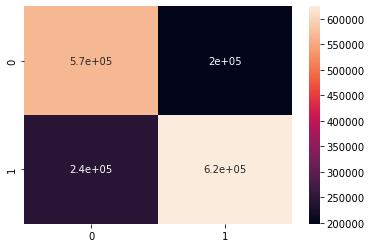

In [14]:
report(y_test['process'].to_cupy(), cp.array(y_pred_rf))

In [15]:
dtest = xgb.DMatrix(data=X_test)
y_pred = bst.predict(dtest).astype(int)

              precision    recall  f1-score   support

           0       0.71      0.74      0.73    764697
           1       0.76      0.74      0.75    869061

    accuracy                           0.74   1633758
   macro avg       0.74      0.74      0.74   1633758
weighted avg       0.74      0.74      0.74   1633758

Sensitivity:  0.74
Specificity:  0.74


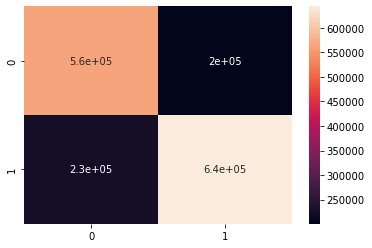

In [16]:
report(y_test['process'].to_cupy(), cp.array(y_pred))

Both model achieved scores similar to those they achieved in the validation stage. The following table summerizes the different metrics measured for both models:


                     |  RF   |  xgb   
    -----------------|-------|-------
    accuracy         |  73%  |  74%     
    avg precision    |  73%  |  74%
    avg recall       |  73%  |  74%
    specifity        |  74%  |  74%  
    
    (RF) Random Forest  (xgb) XGBoost

Both models performed comparably well, with accuracy rates of 73% and 74%. Both models had slightly better percision for the signal process class than the other. Random forest had a slightly less recall for the target class. Choosing either models will be suitable for the current task. Since xgboost had slightly better results, the xgboost model will be chosen as the better match for the Higgs boson process classification.

---

## Conclusion

This study implemented a GPU-based machine learning technique for classifying between a signal process that produces Higgs bosons and a background process that does not. Three models, Logistic Regression, Random Forest classifier, and XGBoost, were trained and evaluated for baseline comparison. The highest achieved accuracy of 74% was by the XGBoost model. Further experimentation was applied to the models to assess their effectiveness, including grid search and hyperparameter tuning. The best version of each model was validated. The top 2 models achieved similar accuracy rates of 73% and 74% when tested on the test split. XGBoost performed slightly better, with better precision for the signal process class. Therefore, the XGBoost model is recommended as the better match for the Higgs boson process classification.

This study demonstrates the potential of using GPU-based machine learning techniques and deep learning methods for assisting in particle physics tasks. The results demonstrate the power of RAPIDS framework for handling large datasets in less time and with less computational power compared to the CPU-based alternatives.